**Topics as Aspects**<br>
**Fine-Tuning of ROBERTA using Contrastive Learning**<br>
**Aspect-Based Sentiment using Fine-tuned ROBERTA**<br>

In [ ]:
import json
import re
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split

c:\Users\koole\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
# -------------------
# 1. Load & Clean Data
# -------------------
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

df = pd.DataFrame([
    {
        "channel": channel,
        "video_id": video_id,
        "video_title": video_data.get("video_title", ""),
        "timestamp": comment["Timestamp"],
        "comment": comment["Comment"],
        "topics": video_data.get("topic", [])
    }
    for channel, playlists in data.items()
    for playlist_id, videos in playlists.items()
    for video_id, video_data in videos.items()
    for comment in video_data.get("comments", [])
])


In [3]:
df.head()

channel     video_id video_title             timestamp  \
0  Fully Charged Show  ZLKh8w3SGr0              2024-07-22T20:50:29Z   
1  Fully Charged Show  ZLKh8w3SGr0              2023-08-31T23:33:42Z   
2  Fully Charged Show  ZLKh8w3SGr0              2023-08-31T14:54:58Z   
3  Fully Charged Show  ZLKh8w3SGr0              2023-06-09T23:35:28Z   
4  Fully Charged Show  ZLKh8w3SGr0              2023-06-01T18:02:16Z   

                                             comment  \
0  hi.  so you Guy proud of it please prove by buy 1   
1  Tesla still the electric car to beat especiall...   
2                            This didn’t age well……😂   
3                  Good luck VIETNAMESE Electric Car   
4  Why can't Mexico or any Latin American country...   

                                              topics  
0  [horsepower, ccs, tesla, range, software updat...  
1  [horsepower, ccs, tesla, range, software updat...  
2  [horsepower, ccs, tesla, range, software updat...  
3  [horsepower, ccs, tesla, range, software updat...  
4  [horsepower, ccs, tesla, range, software updat...

In [4]:
# Clean Text
def clean_text(text):
    if isinstance(text, list): text = ' '.join(text)
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = ' '.join([w for w in text.split() if w not in stopwords.words("english")])
    return text.strip()

df["cleaned_text"] = df["comment"].apply(clean_text)

In [5]:
df.head()

channel     video_id video_title             timestamp  \
0  Fully Charged Show  ZLKh8w3SGr0              2024-07-22T20:50:29Z   
1  Fully Charged Show  ZLKh8w3SGr0              2023-08-31T23:33:42Z   
2  Fully Charged Show  ZLKh8w3SGr0              2023-08-31T14:54:58Z   
3  Fully Charged Show  ZLKh8w3SGr0              2023-06-09T23:35:28Z   
4  Fully Charged Show  ZLKh8w3SGr0              2023-06-01T18:02:16Z   

                                             comment  \
0  hi.  so you Guy proud of it please prove by buy 1   
1  Tesla still the electric car to beat especiall...   
2                            This didn’t age well……😂   
3                  Good luck VIETNAMESE Electric Car   
4  Why can't Mexico or any Latin American country...   

                                              topics  \
0  [horsepower, ccs, tesla, range, software updat...   
1  [horsepower, ccs, tesla, range, software updat...   
2  [horsepower, ccs, tesla, range, software updat...   
3  [horsepower, ccs, tesla, range, software updat...   
4  [horsepower, ccs, tesla, range, software updat...   

                                        cleaned_text  
0                      hi guy proud please prove buy  
1  tesla still electric car beat especially drop ...  
2                                     didnt age well  
3                  good luck vietnamese electric car  
4  cant mexico latin american country make cars l...

In [6]:
# VADER Sentiment
vader = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return "Positive" if scores["compound"] >= 0.05 else "Negative" if scores["compound"] <= -0.05 else "Neutral"

df["sentiment_vader"] = df["cleaned_text"].apply(get_vader_sentiment)

In [7]:
# Initialize RoBERTa for Sequence Classification
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3).to("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Triplet Dataset
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets

    def __len__(self):
        return len(self.triplets)

    def __getitem__(self, idx):
        return self.triplets[idx]

# Function to encode text using tokenizer
def encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    return inputs.to(model.device)

def get_embedding(text):
    inputs = encode(text)
    with torch.no_grad():
        return model.roberta(**inputs).last_hidden_state.mean(dim=1)  # Get the mean of the hidden states for the embedding

# Function to generate triplet samples
def generate_triplets(df, max_triplets=5000):
    sentiments = {s: df[df["sentiment_vader"] == s]["cleaned_text"].tolist() for s in ["Positive", "Negative", "Neutral"]}
    triplets = []
    for s, examples in sentiments.items():
        if len(examples) < 2: continue
        for _ in range(min(max_triplets, len(examples))):
            a, p = random.sample(examples, 2)
            n_source = random.choice([v for k, v in sentiments.items() if k != s])
            n = random.choice(n_source)
            triplets.append((a, p, n))
    return triplets



# Step 1: Split the data before generating triplets
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["sentiment_vader"], random_state=42)

# Step 2: Generate triplets for training and testing separately
train_triplets = generate_triplets(train_df)
test_triplets = generate_triplets(test_df)

# Step 3: Create loaders
train_loader = DataLoader(TripletDataset(train_triplets), batch_size=16, shuffle=True)
test_loader = DataLoader(TripletDataset(test_triplets), batch_size=16, shuffle=False)

# # Generate Triplets
# triplets = generate_triplets(df)
# triplet_loader = DataLoader(TripletDataset(triplets), batch_size=16, shuffle=True)

# Triplet Loss function
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_sim = F.cosine_similarity(anchor, positive)
    neg_sim = F.cosine_similarity(anchor, negative)
    return torch.mean(F.relu(margin + neg_sim - pos_sim))

In [ ]:
# Training Loop with Triplet Loss + Cross-Entropy for Classification
model.train()
optimizer = AdamW(model.parameters(), lr=5e-5)
classification_loss_fn = torch.nn.CrossEntropyLoss()

# Train for 3 epochs
for epoch in range(3):
    total_loss = 0
    print(f"Epoch {epoch+1}")
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}", unit="batch") as pbar:
        for anchor, positive, negative in train_loader:
            # Get embeddings for triplet loss
            a_embed = get_embedding(anchor)
            p_embed = get_embedding(positive)
            n_embed = get_embedding(negative)

            # Compute triplet loss
            loss_triplet = triplet_loss(a_embed, p_embed, n_embed)

            # Now use the anchor for classification task
            inputs = encode(anchor)

            # Efficiently get sentiment labels for anchor batch from df
            labels = []
            for a in anchor:
                # Find the sentiment label for each anchor
                sentiment = df.loc[df["cleaned_text"] == a, "sentiment_vader"]
                if sentiment.empty:
                    print(f"Warning: No sentiment found for {a}. Using a default label (Neutral).")
                    labels.append("Neutral")  # Default to neutral if no sentiment is found
                else:
                    labels.append(sentiment.iloc[0])

            # Convert the sentiment labels to integer indices
            sentiment_map = {"Negative": 0, "Neutral": 1, "Positive": 2}
            label_indices = torch.tensor([sentiment_map[label] for label in labels]).to(model.device)

            # Forward pass for classification task
            outputs = model(**inputs)
            loss_classification = classification_loss_fn(outputs.logits, label_indices)

            # Total loss is sum of triplet loss and classification loss
            total_loss_batch = loss_triplet + loss_classification
            optimizer.zero_grad()
            total_loss_batch.backward()
            optimizer.step()

            total_loss += total_loss_batch.item()
            pbar.set_postfix({"Loss": f"{total_loss / (pbar.n + 1):.4f}"})
            pbar.update(1)

    print(f"Avg Loss: {total_loss / len(train_loader):.4f}")


Epoch 1


Epoch 1: 100%|██████████| 938/938 [12:27<00:00,  1.25batch/s, Loss=1.1847]


Avg Loss: 1.1847
Epoch 2


Epoch 2: 100%|██████████| 938/938 [12:26<00:00,  1.26batch/s, Loss=0.7679]


Avg Loss: 0.7679
Epoch 3


Epoch 3: 100%|██████████| 938/938 [12:24<00:00,  1.26batch/s, Loss=0.5406]

Avg Loss: 0.5406


In [12]:
# Save the fine-tuned model
model.save_pretrained("fine-tuned-roberta-triplet-classification")
tokenizer.save_pretrained("fine-tuned-roberta-triplet-classification")
torch.save(model.state_dict(), "fine-tuned-roberta-triplet-classification/pytorch_model.bin")


✅ Accuracy: 0.8886

📊 Classification Report:
              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82      2166
     Neutral       0.91      0.88      0.89      2353
    Positive       0.94      0.90      0.92      5000

    accuracy                           0.89      9519
   macro avg       0.87      0.88      0.88      9519
weighted avg       0.89      0.89      0.89      9519



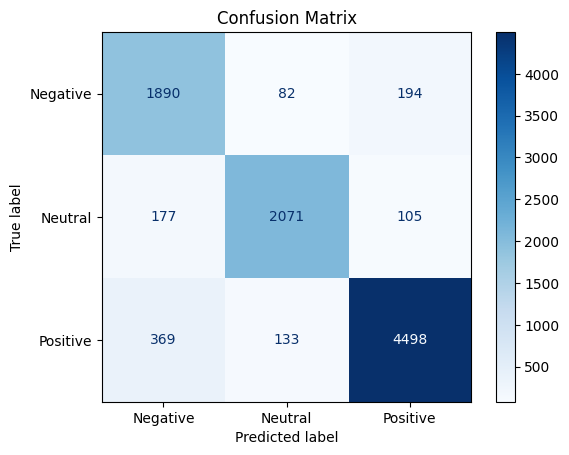

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Prepare LabelEncoder once for mapping 'sentiment_vader' to numeric
le = LabelEncoder()
le.fit(df["sentiment_vader"])

# Evaluation
model.eval()
all_preds = []
all_true = []

with torch.no_grad():
    for batch in test_loader:  # Use test_loader here for evaluation
        anchor, positive, negative = batch

        anchor_texts = anchor  # already raw text

        # Tokenize again for classification
        inputs = encode(anchor_texts)

        # Lookup sentiment labels for the anchor texts
        labels_str = [df[df["cleaned_text"] == a]["sentiment_vader"].iloc[0] for a in anchor_texts]
        labels = torch.tensor(le.transform(labels_str)).to(model.device)

        # Get predictions
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(predictions.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

# Accuracy
accuracy = accuracy_score(all_true, all_preds)
print(f"\n✅ Accuracy: {accuracy:.4f}")

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(all_true, all_preds, target_names=["Negative", "Neutral", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(all_true, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Neutral", "Positive"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


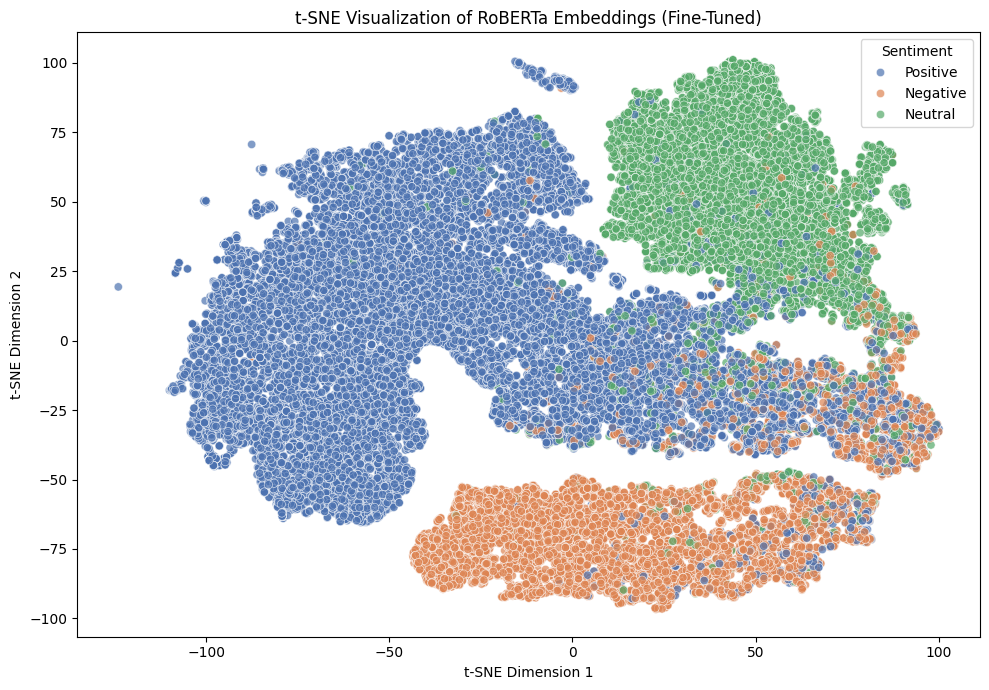

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # Import numpy for array operations
from sklearn.preprocessing import LabelEncoder

# ... (Your previous code here) ...

# Get embeddings and labels for the entire dataset
model.eval()  # Ensure model is in evaluation mode
all_embeddings = []
all_sentiments = []

with torch.no_grad():
    for index in range(len(df)):
        text = df.iloc[index]['cleaned_text']
        # Check if text is a valid string
        if isinstance(text, str) and text:  # Check for both string type and non-empty string
            embedding = get_embedding(text).cpu().numpy()
            all_embeddings.append(embedding.flatten())
        else:
            # Handle invalid text (e.g., NaN, empty string) - skip or use default embedding
            print(f"Warning: Invalid text at index {index}. Skipping.")
            continue  # Skip to the next iteration
            # Or, use a default embedding:
            # embedding = np.zeros(model.config.hidden_size) # Example default embedding
            # all_embeddings.append(embedding)

        all_sentiments.append(df.iloc[index]['sentiment_vader'])

# Convert embeddings and labels to numpy arrays
X = np.array(all_embeddings)  # Create the feature matrix X
le = LabelEncoder()  # Encode labels for visualization with t-SNE
y = le.fit_transform(all_sentiments)

# Dimensionality reduction with PCA (optional before t-SNE to speed up)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# t-SNE for visualization (2D)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, init="pca", learning_rate="auto", n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)

# Plotting
vis_df = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "sentiment": le.inverse_transform(y)  # Decode labels for plot
})

plt.figure(figsize=(10, 7))
sns.scatterplot(data=vis_df, x="x", y="y", hue="sentiment", palette="deep", alpha=0.7)
plt.title("t-SNE Visualization of RoBERTa Embeddings (Fine-Tuned)")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

In [27]:
import torch
from torch import nn
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the fine-tuned model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("fine-tuned-roberta-triplet-classification").to("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("fine-tuned-roberta-triplet-classification")

In [28]:
def predict_sentiment(text):
    # Tokenize the text and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(model.device)

    # Get the model's prediction (logits)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Get the predicted class index (use argmax directly on logits)
    sentiment_class = torch.argmax(logits, dim=1).item()

    # Map the class index to sentiment label
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    sentiment = sentiment_labels[sentiment_class]

    return sentiment

# Apply the function to the cleaned text in your DataFramec
df["sentiment_roberta"] = df["cleaned_text"].apply(predict_sentiment)

# Example to see the new DataFrame with the predicted sentiment
print(df[["comment", "sentiment_roberta"]].head())

                                             comment sentiment_roberta
0  hi.  so you Guy proud of it please prove by buy 1          Positive
1  Tesla still the electric car to beat especiall...          Negative
2                            This didn’t age well……😂          Negative
3                  Good luck VIETNAMESE Electric Car          Positive
4  Why can't Mexico or any Latin American country...          Negative


In [29]:
df.to_csv("comment_sentiment_roberta_FineTuning.csv", index=False)

In [30]:
df.columns

Index(['channel', 'video_id', 'video_title', 'timestamp', 'comment', 'topics',
       'cleaned_text', 'sentiment_vader', 'sentiment_roberta'],
      dtype='object')

In [31]:
df.to_csv("comment_sentiment_roberta_and_vader.csv", index=True)

In [132]:
df = pd.read_csv("comment_sentiment_roberta_FineTuning.csv")
df.columns

Index(['channel', 'video_id', 'video_title', 'timestamp', 'comment', 'topics',
       'cleaned_text', 'sentiment_vader', 'sentiment_roberta'],
      dtype='object')

# VADER

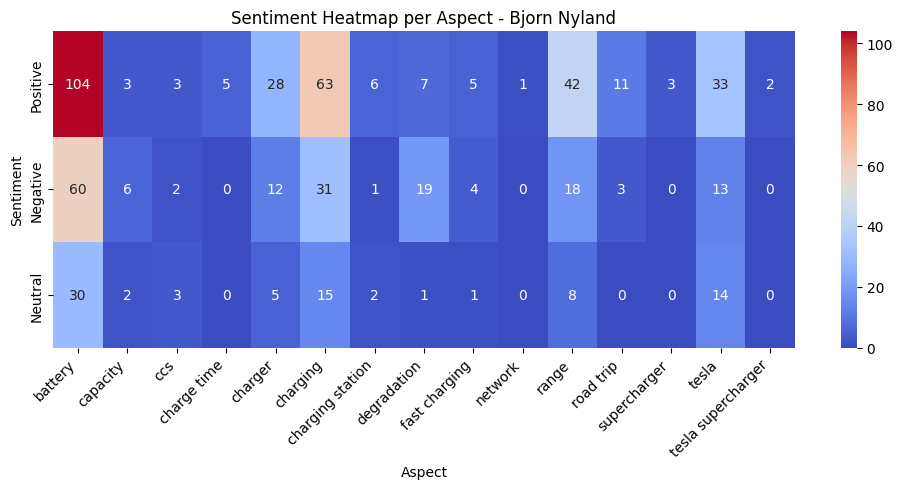

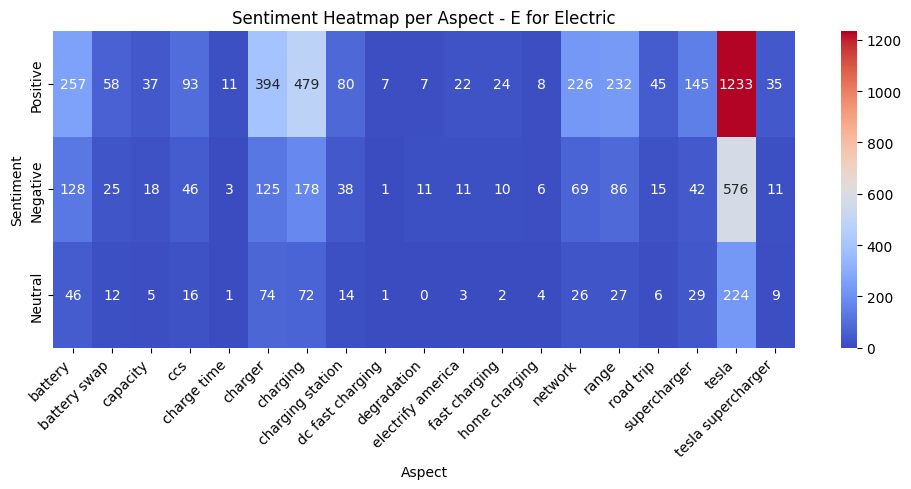

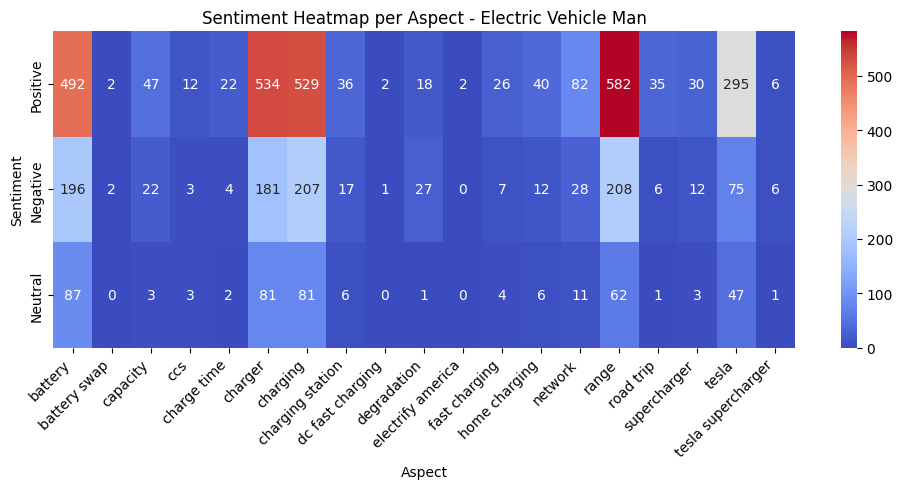

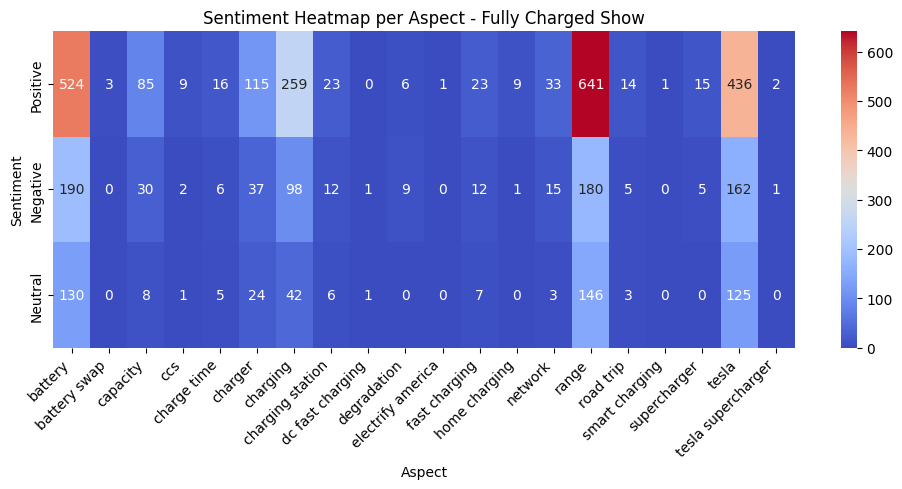

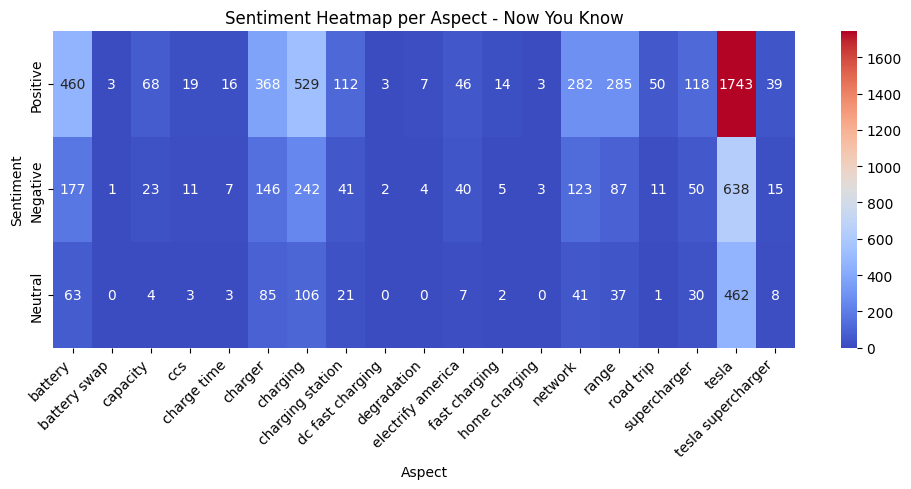

In [115]:
#ABSA heatmap per channel

def find_matching_aspects(comment, topics):
    if isinstance(comment, str):
        return [aspect for aspect in topics if aspect in comment.lower()]
    return []  # Return empty list if comment is not valid


df["matched_aspects"] = df["cleaned_text"].apply(lambda x: find_matching_aspects(x, topics))


df_expanded = df.explode("matched_aspects")
df_expanded = df_expanded.dropna(subset=["matched_aspects"])  # Drop rows where no top aspect was matched

grouped = df_expanded.groupby(["channel", "matched_aspects", "sentiment_vader"]).size().unstack(fill_value=0).reset_index()

for channel in grouped["channel"].unique():
    subset = grouped[grouped["channel"] == channel].set_index("matched_aspects")[["Positive", "Negative", "Neutral"]]
    plt.figure(figsize=(10, 5))
    sns.heatmap(subset.T, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Sentiment Heatmap per Aspect - {channel}")
    plt.ylabel("Sentiment")
    plt.xlabel("Aspect")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [54]:
grouped.to_csv("topic_sentiment_per_creator_vader.csv", index=True)

In [35]:
# Aspect-Based Sentiment Comparison Among Creators
# Summarize sentiment distribution per creator
sentiment_counts_vader = df.groupby(['channel', 'sentiment_vader']).size().unstack(fill_value=0)
sentiment_counts_vader = sentiment_counts_vader[['Positive', 'Neutral', 'Negative']]  # Ensure the correct order

In [36]:
sentiment_df_vader = pd.DataFrame(sentiment_counts_vader).T.reset_index()
sentiment_df_vader.to_csv("vader_sentiment_counts.csv", index=False)

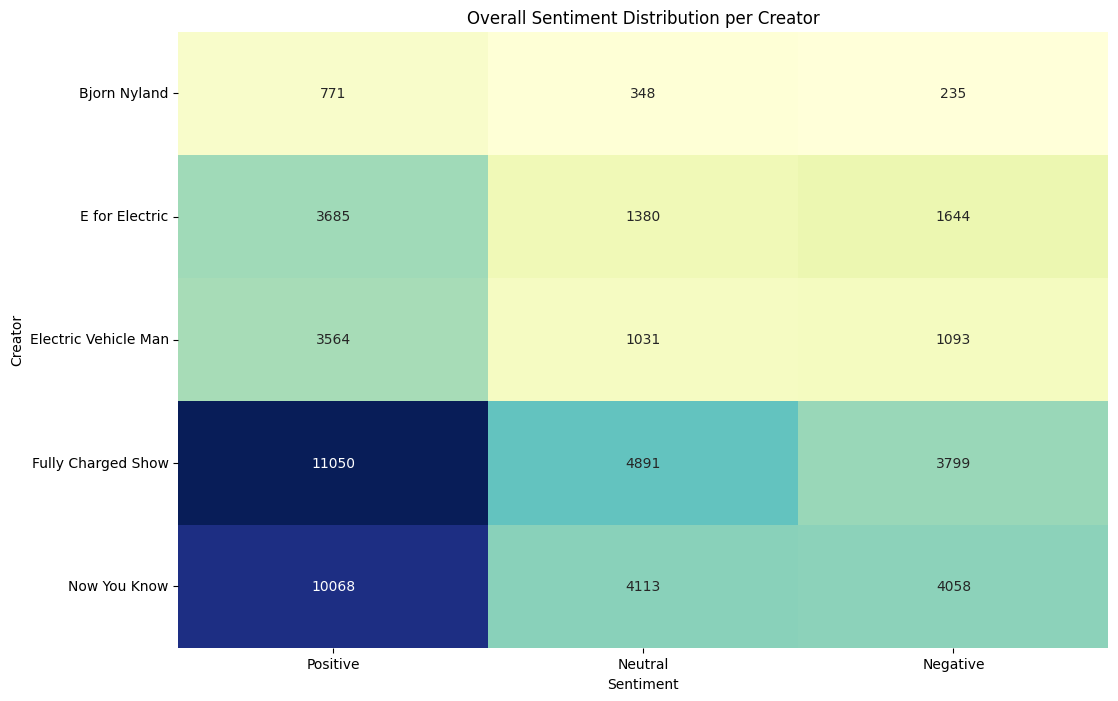

In [37]:
# Plot the heatmap for overall sentiment distribution per creator
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_counts_vader, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title('Overall Sentiment Distribution per Creator')
plt.xlabel('Sentiment')
plt.ylabel('Creator')
plt.show()

C:\Users\koole\AppData\Local\Temp\ipykernel_25872\896370331.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


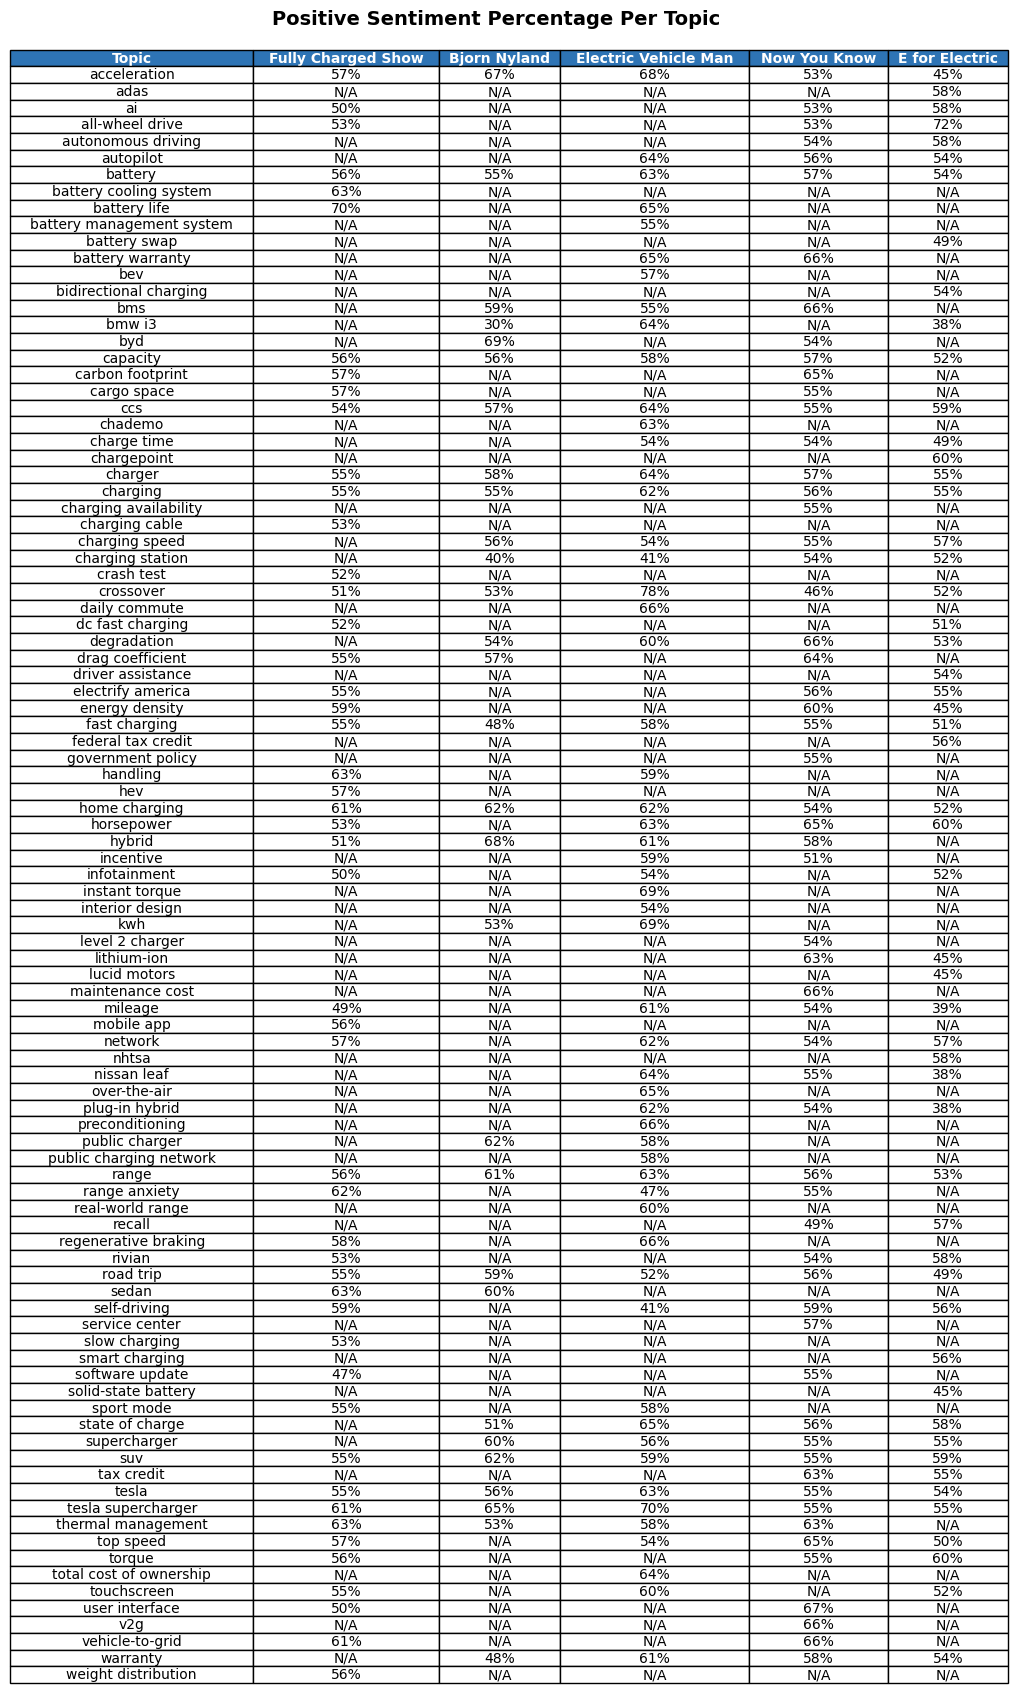

In [38]:
from itertools import chain

# Flatten the list of lists and get unique topics
all_topics = set(chain.from_iterable(df["topics"]))
top_topics_df = pd.DataFrame(sorted(all_topics), columns=["Topic"])

# Initialize dictionary to store sentiment counts per creator
sentiment_counts = {topic: {} for topic in top_topics_df["Topic"]}

# Process sentiment data
for creator in df["channel"].unique():
    creator_df = df[df["channel"] == creator]
    
    for topic in top_topics_df["Topic"]:
        total_mentions = 0
        positive_mentions = 0
        
        for topics, sentiment in zip(creator_df["topics"], creator_df["sentiment_vader"]):
            if topic in topics:  # ✅ Check if the topic is in the list
                total_mentions += 1
                if str(sentiment).strip().lower() == "positive":
                    positive_mentions += 1
        
        sentiment_counts[topic][creator] = (
            f"{(positive_mentions / total_mentions * 100):.0f}%" if total_mentions > 0 else "N/A"
        )


# Convert sentiment data to DataFrame
sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
sentiment_df.columns = ["Topic"] + list(df["channel"].unique())

# Plot the Table
fig, ax = plt.subplots(figsize=(10, 4))

# Hide axes
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(cellText=sentiment_df.values, 
                 colLabels=sentiment_df.columns, 
                 cellLoc="center", 
                 loc="center")

# Style the Table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([i for i in range(len(sentiment_df.columns))])

# Highlight header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight="bold", color="white")
        cell.set_facecolor("#2E74B5")  # Blue Header

# Add title above the table using fig.text
fig.text(0.5, 2.6, "Positive Sentiment Percentage Per Topic", fontsize=14, weight="bold", ha="center")

plt.tight_layout()
plt.show()

In [39]:
sentiment_df.head()
sentiment_df.to_csv("topic_sentiment_summary_vader.csv", index=False)

C:\Users\koole\AppData\Local\Temp\ipykernel_25872\3466848883.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="topics", y="Count", hue="Sentiment", palette="Set2", ci=None)


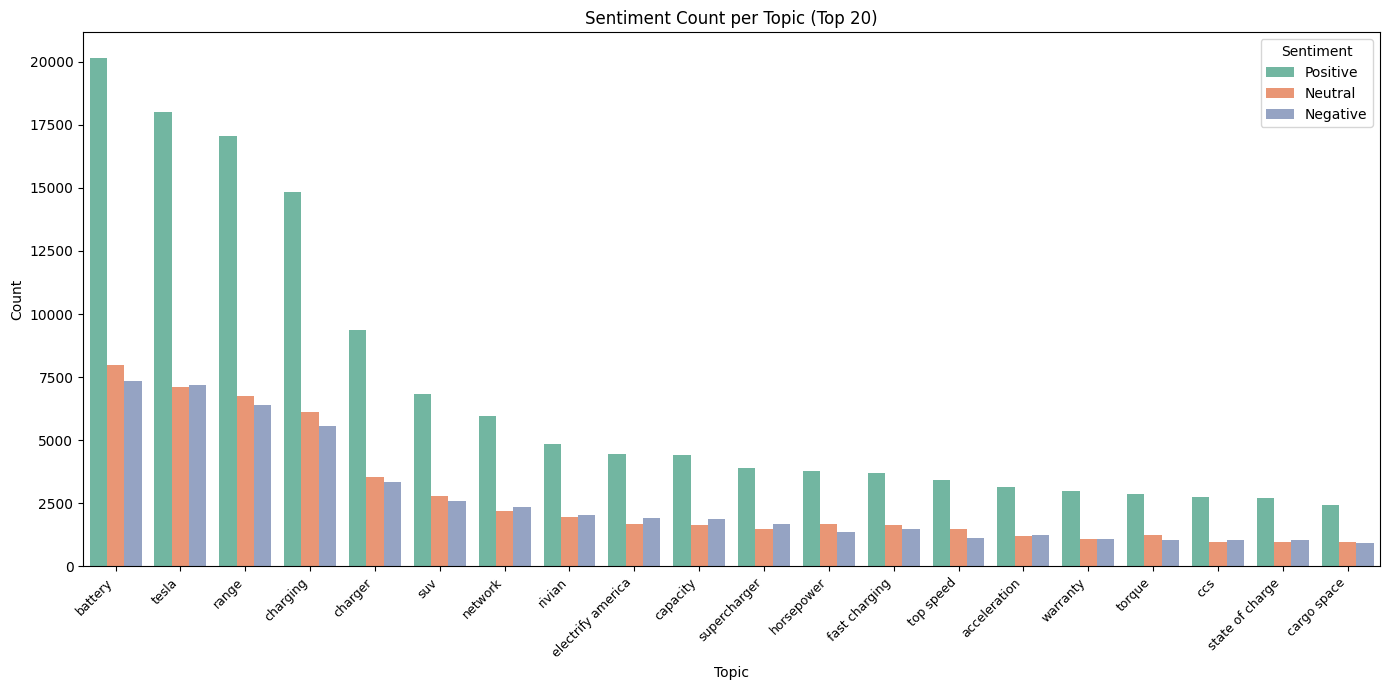

In [118]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Step 1: Load the data
df = pd.read_csv("comment_sentiment_roberta_FineTuning.csv")

# Step 2: Remove existing sentiment columns if they exist
df = df.drop(columns=["Negative", "Neutral", "Positive"], errors="ignore")

# Step 3: Convert stringified lists in 'topics' column to actual Python lists
def safe_parse_topics(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return [x]

df["topics"] = df["topics"].apply(safe_parse_topics)

# Step 4: One-hot encode sentiment_roberta column
df_sentiment = pd.get_dummies(df["sentiment_vader"])  # Creates 'Negative', 'Neutral', 'Positive'
df = pd.concat([df, df_sentiment], axis=1)

# Step 5: Explode the topics
df_exploded = df.explode("topics")
df_exploded["topics"] = df_exploded["topics"].astype(str).str.lower().str.strip()

# Step 6: Group and aggregate sentiment counts
df_grouped = df_exploded.groupby("topics", as_index=False)[["Negative", "Neutral", "Positive"]].sum()

# Step 7: Get top 20 topics by total sentiment count
df_grouped["Total"] = df_grouped[["Negative", "Neutral", "Positive"]].sum(axis=1)
df_grouped = df_grouped.sort_values("Total", ascending=False).head(20)

# Step 8: Melt the data for seaborn
df_melted = df_grouped.melt(id_vars="topics",
                            value_vars=["Positive", "Neutral", "Negative"],
                            var_name="Sentiment", value_name="Count")

# Step 9: Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="topics", y="Count", hue="Sentiment", palette="Set2", ci=None)
plt.title("Sentiment Count per Topic (Top 20)")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


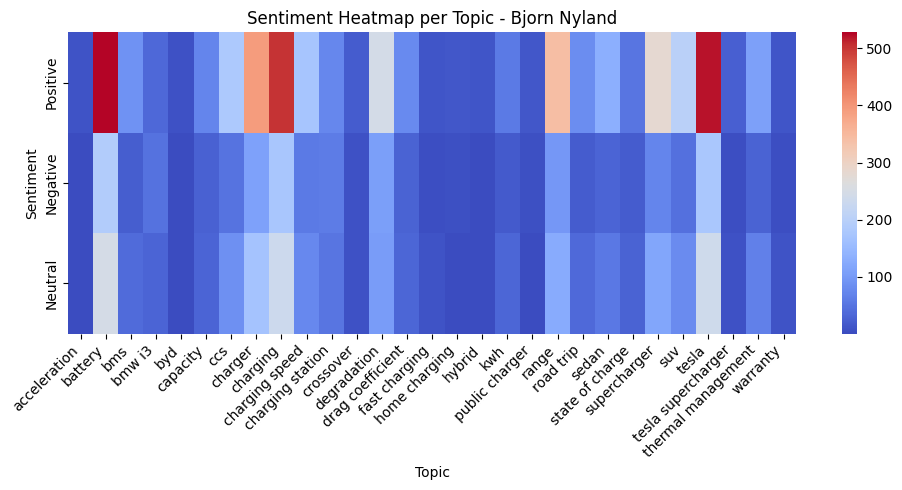

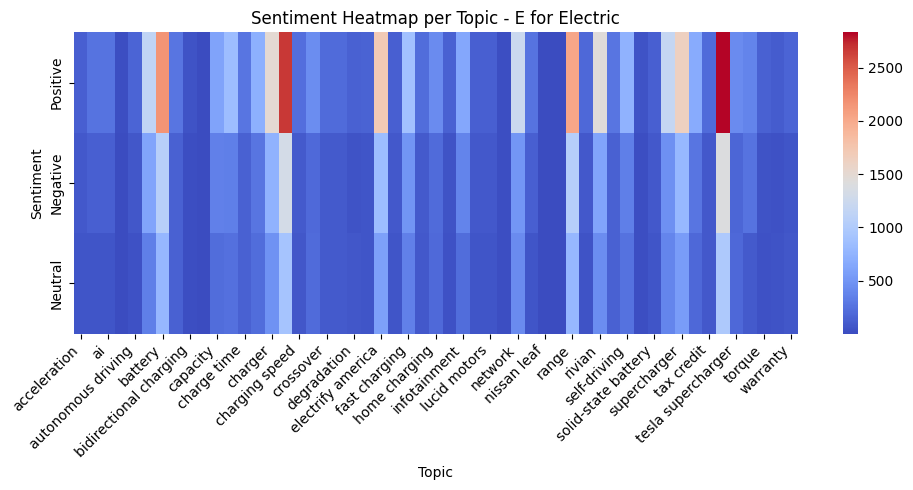

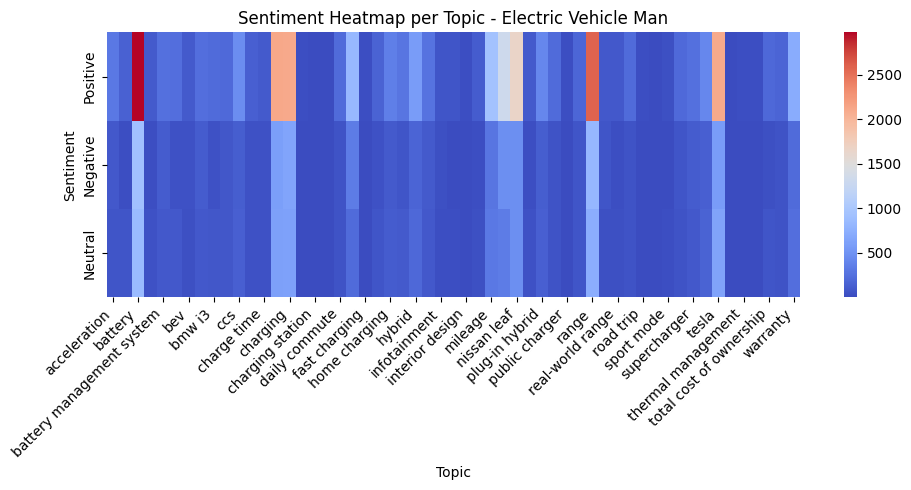

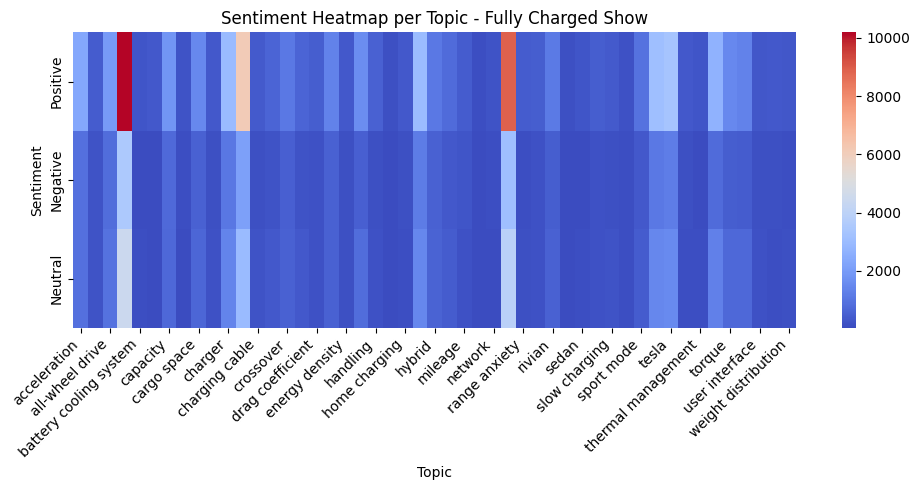

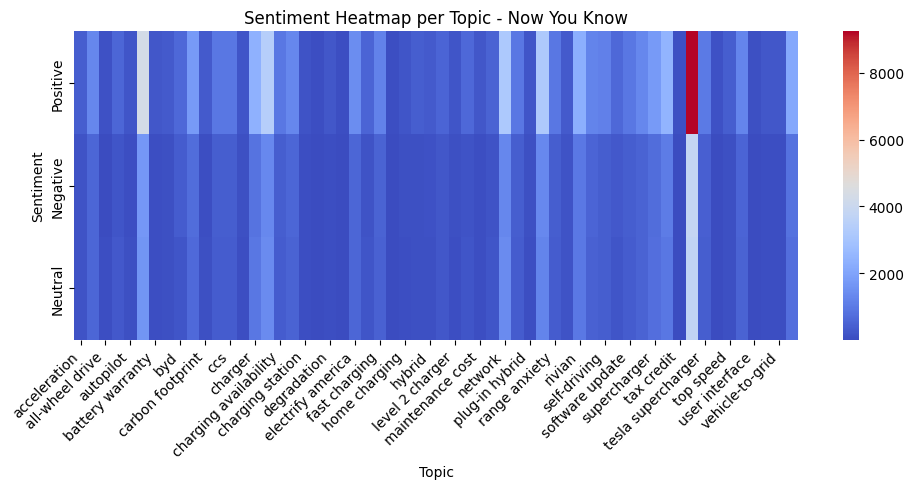

In [68]:
# ABSA heatmap per channel
df_expanded = df.explode("topics")
grouped = df_expanded.groupby(["channel", "topics", "sentiment_vader"]).size().unstack(fill_value=0).reset_index()

for channel in grouped["channel"].unique():
    subset = grouped[grouped["channel"] == channel].set_index("topics")[["Positive", "Negative", "Neutral"]]
    plt.figure(figsize=(10, 5))
    sns.heatmap(subset.T, annot=False, fmt="d", cmap="coolwarm")
    plt.title(f"Sentiment Heatmap per Topic - {channel}")
    plt.ylabel("Sentiment")
    plt.xlabel("Topic")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [69]:
grouped.to_csv("topic_sentiment_per_creator_vader.csv", index=True)

C:\Users\koole\AppData\Local\Temp\ipykernel_25872\80756993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")


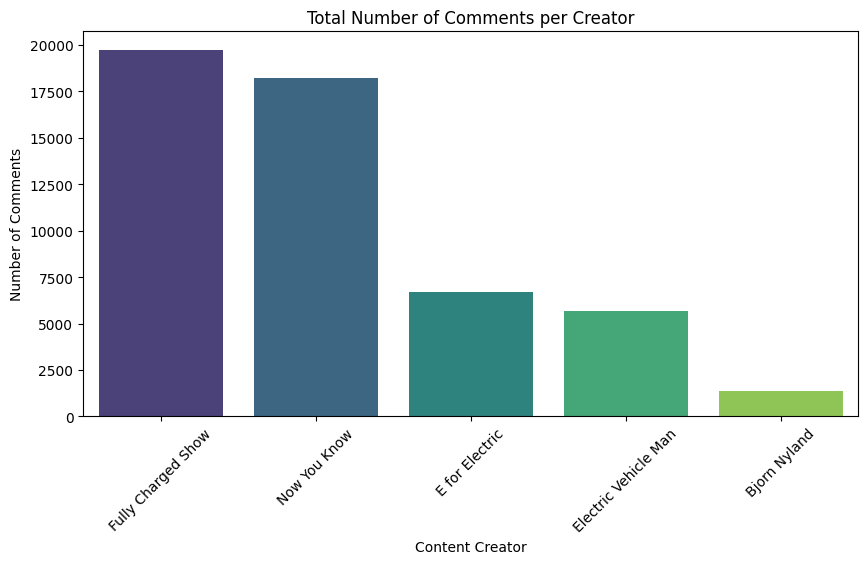

In [70]:
total_comments = df["channel"].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")
plt.title("Total Number of Comments per Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()

In [ ]:
total_comments.to_csv("total_comments.csv", index=True)

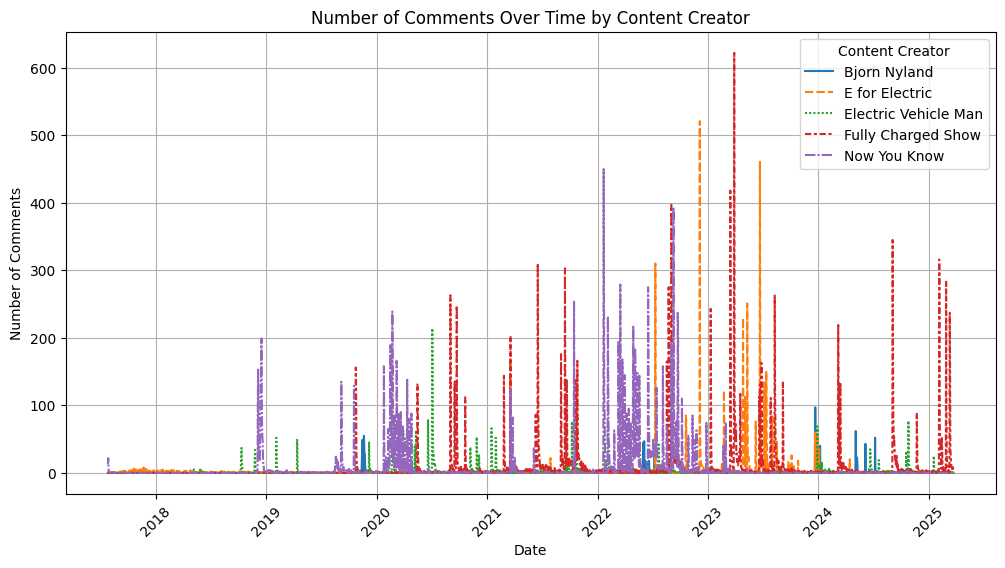

In [ ]:
# Time series of the number of comments received per creator
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

comment_time_series = df.groupby(["date", "channel"]).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.lineplot(data=comment_time_series)
plt.title("Number of Comments Over Time by Content Creator")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Content Creator")
plt.grid()
plt.show()

In [ ]:
comment_time_series.to_csv("comment_time_series.csv", index=True)

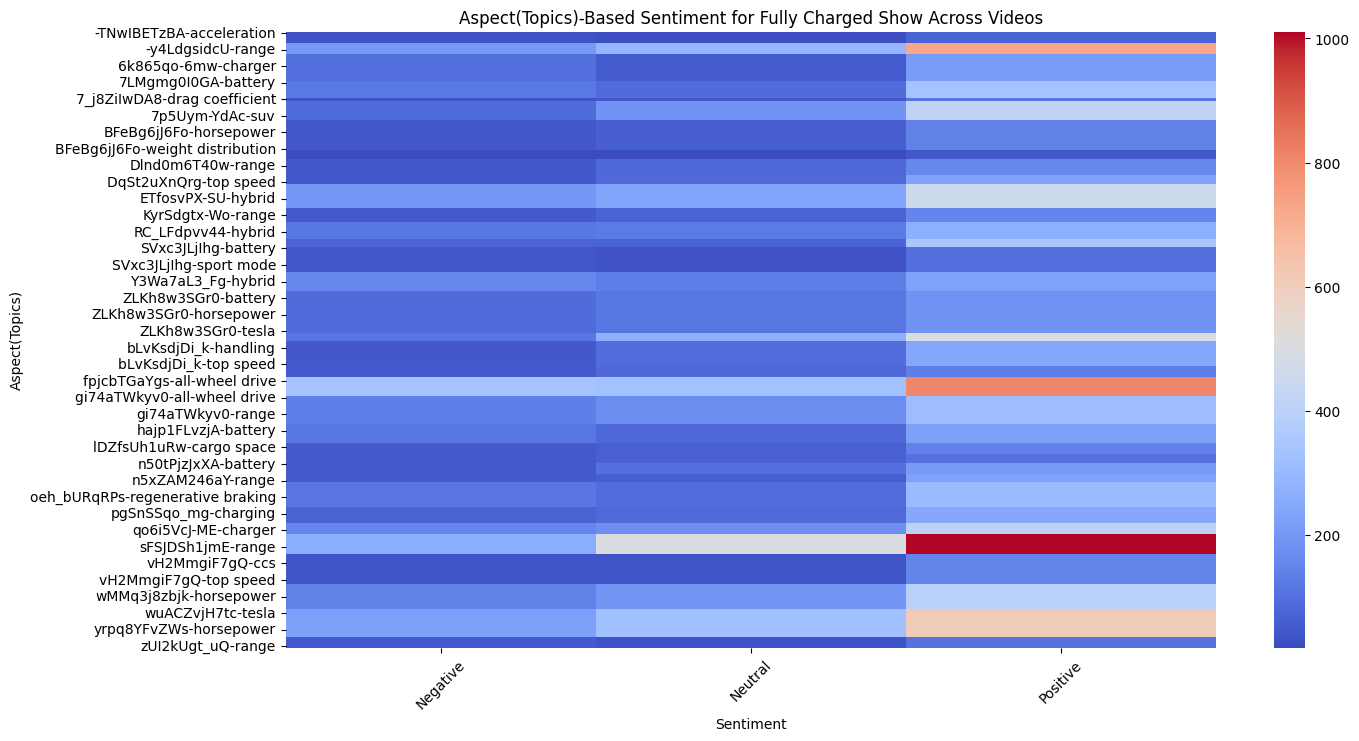

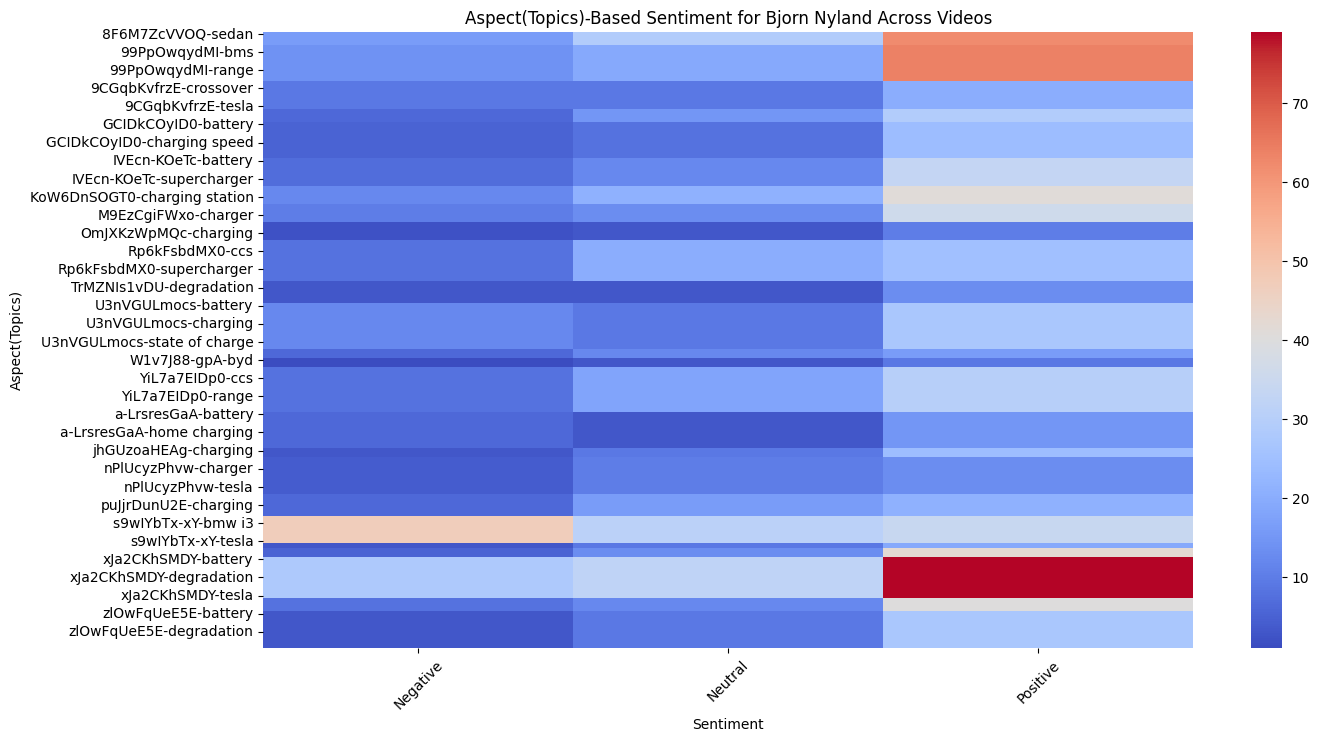

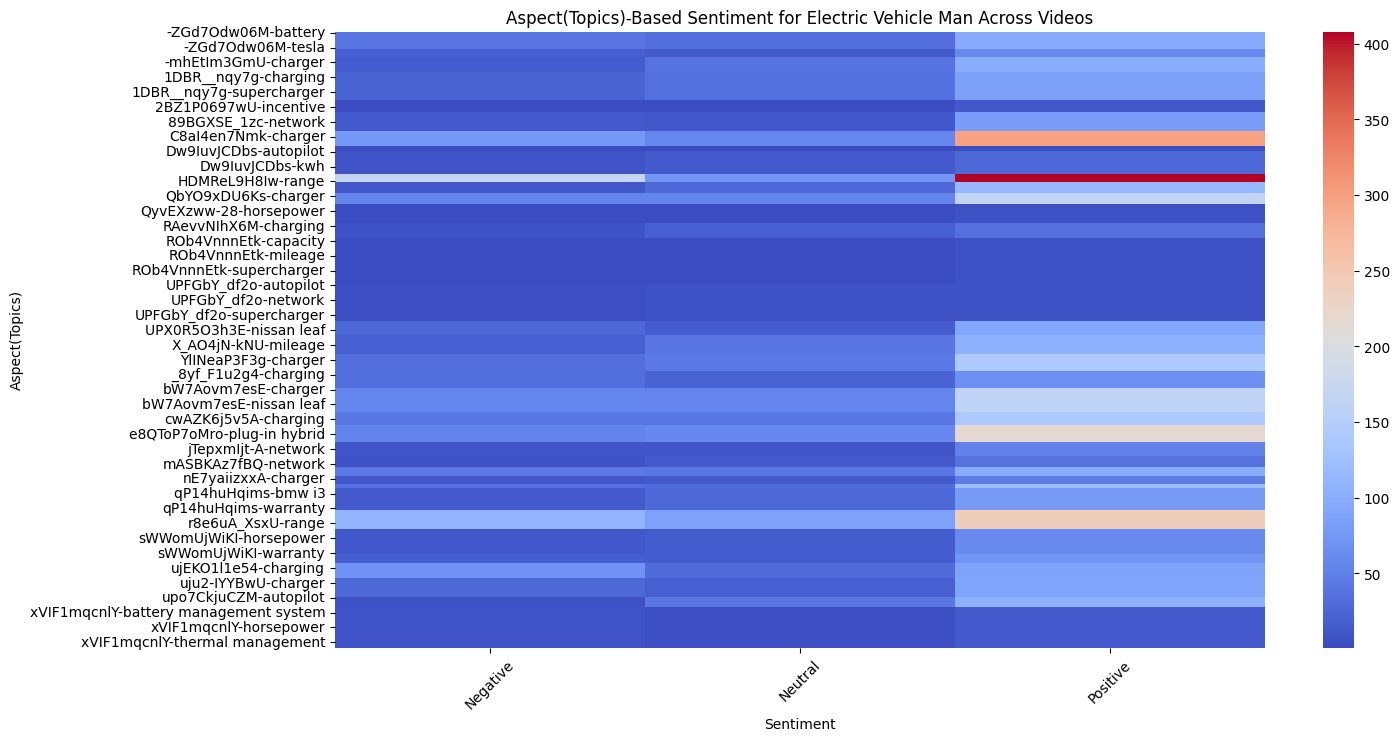

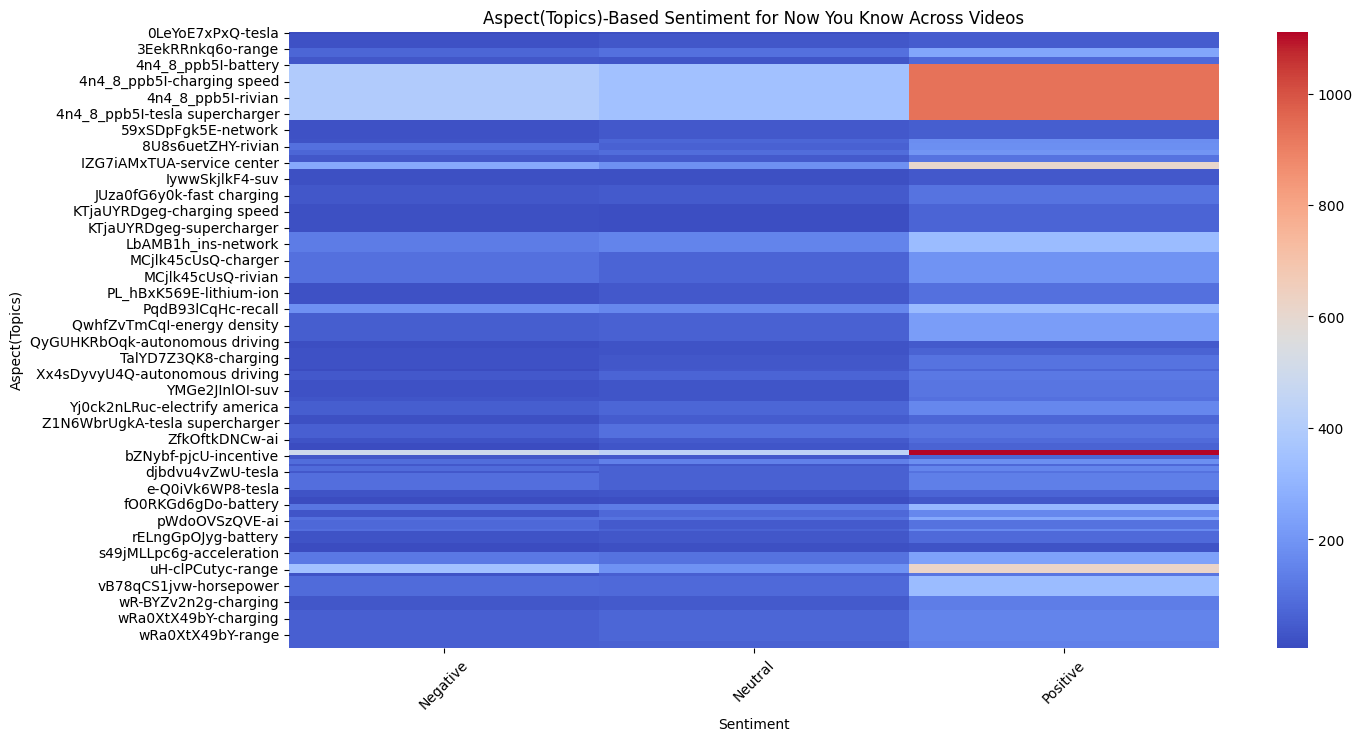

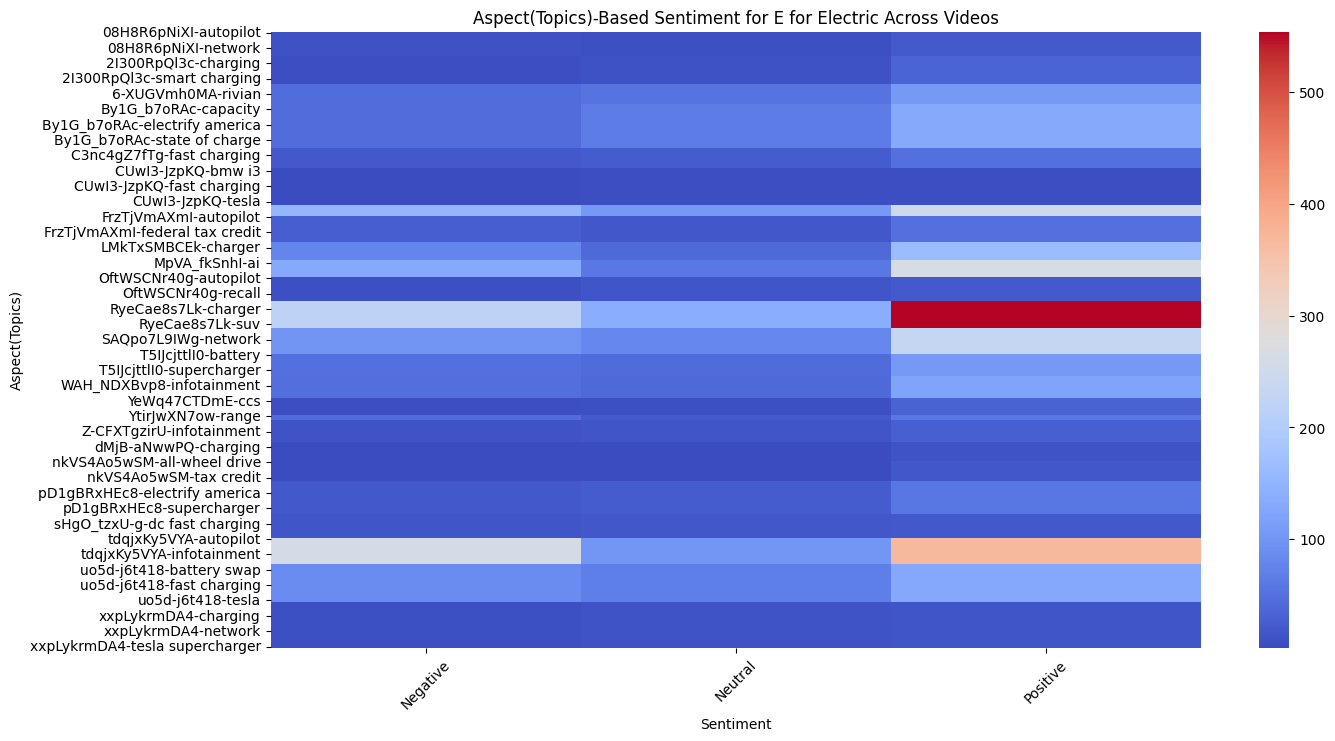

In [ ]:
for creator in df["channel"].unique():
    creator_df = df[df["channel"] == creator].explode("topics")
    aspect_video_sentiment = creator_df.groupby(["video_id", "topics", "sentiment_vader"]).size().unstack(fill_value=0)
    plt.figure(figsize=(15, 8))
    #sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=True, fmt="d")
    sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=False, fmt="d")
    plt.title(f"Aspect(Topics)-Based Sentiment for {creator} Across Videos")
    plt.xlabel("Sentiment")
    plt.ylabel("Aspect(Topics)")
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
aspect_video_sentiment.to_csv("aspect_video_sentiment_vader.csv", index=True)

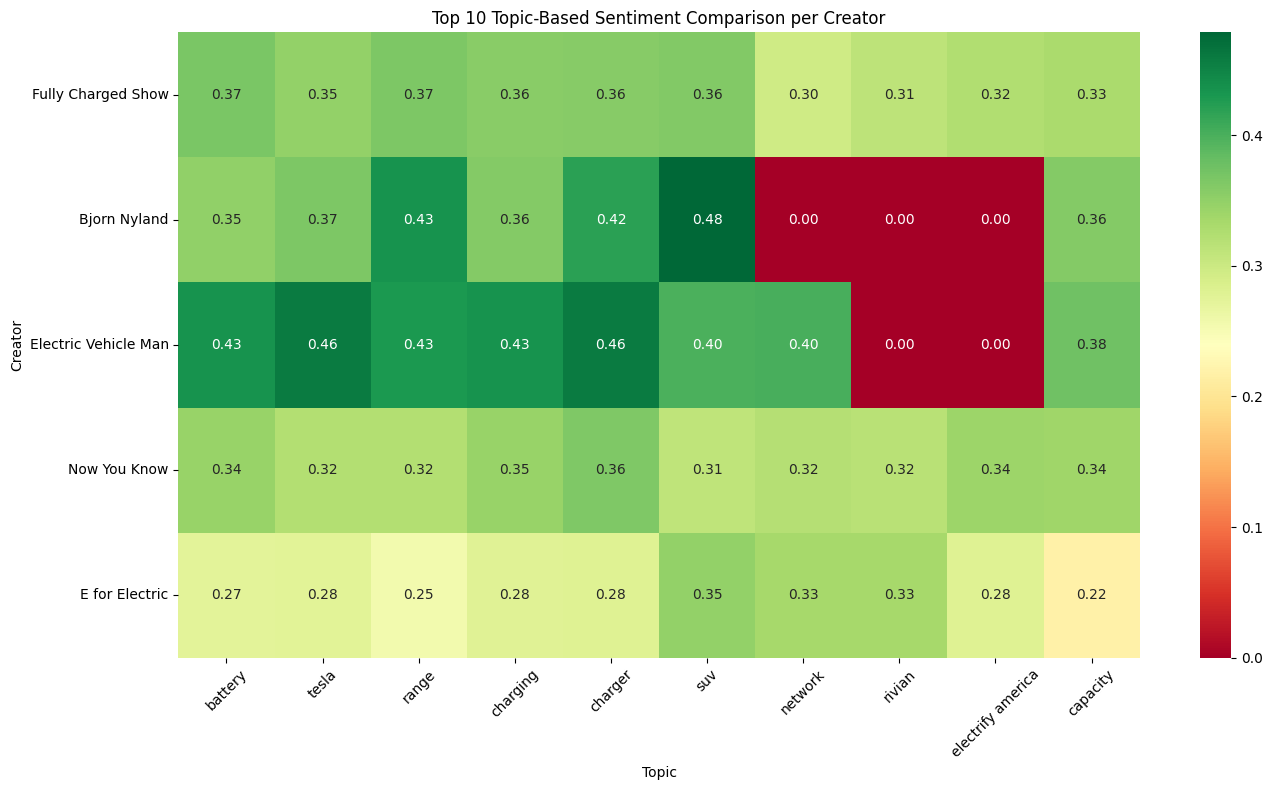

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
df["topics"] = df["topics"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Explode topics column
df_exploded = df.explode("topics")

# Optional: standardize sentiment labels
df_exploded["sentiment_vader"] = df_exploded["sentiment_vader"].str.strip().str.lower()

# Get top N topics
top_topics = df_exploded["topics"].value_counts().head(10).index.tolist()

# Initialize the result matrix
topic_sentiment_matrix = pd.DataFrame()

# Loop through creators
for creator in df_exploded["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    
    # Initialize topic sentiment dict
    topic_scores = {topic: 0 for topic in top_topics}
    topic_counts = {topic: 0 for topic in top_topics}

    # Iterate rows
    for _, row in creator_df.iterrows():
        topic = row["topics"]
        sentiment = row["sentiment_vader"]
        if topic in top_topics:
            if sentiment == "positive":
                topic_scores[topic] += 1
            elif sentiment == "negative":
                topic_scores[topic] -= 1
            topic_counts[topic] += 1

    # Normalize scores
    topic_sentiment_avg = {
        topic: (topic_scores[topic] / topic_counts[topic]) if topic_counts[topic] > 0 else 0
        for topic in top_topics
    }

    topic_sentiment_matrix[creator] = pd.Series(topic_sentiment_avg)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(topic_sentiment_matrix.T, annot=True, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Top 10 Topic-Based Sentiment Comparison per Creator")
plt.xlabel('Topic')
plt.ylabel('Creator')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Save the aspect sentiment matrix to CSV
topic_sentiment_matrix.T.to_csv("Topics_aspect_sentiment_per_creator_vader.csv", index=True)

In [ ]:
topic_sentiment_matrix.to_csv("topic_sentiment_matrix_vader.csv", index=False)

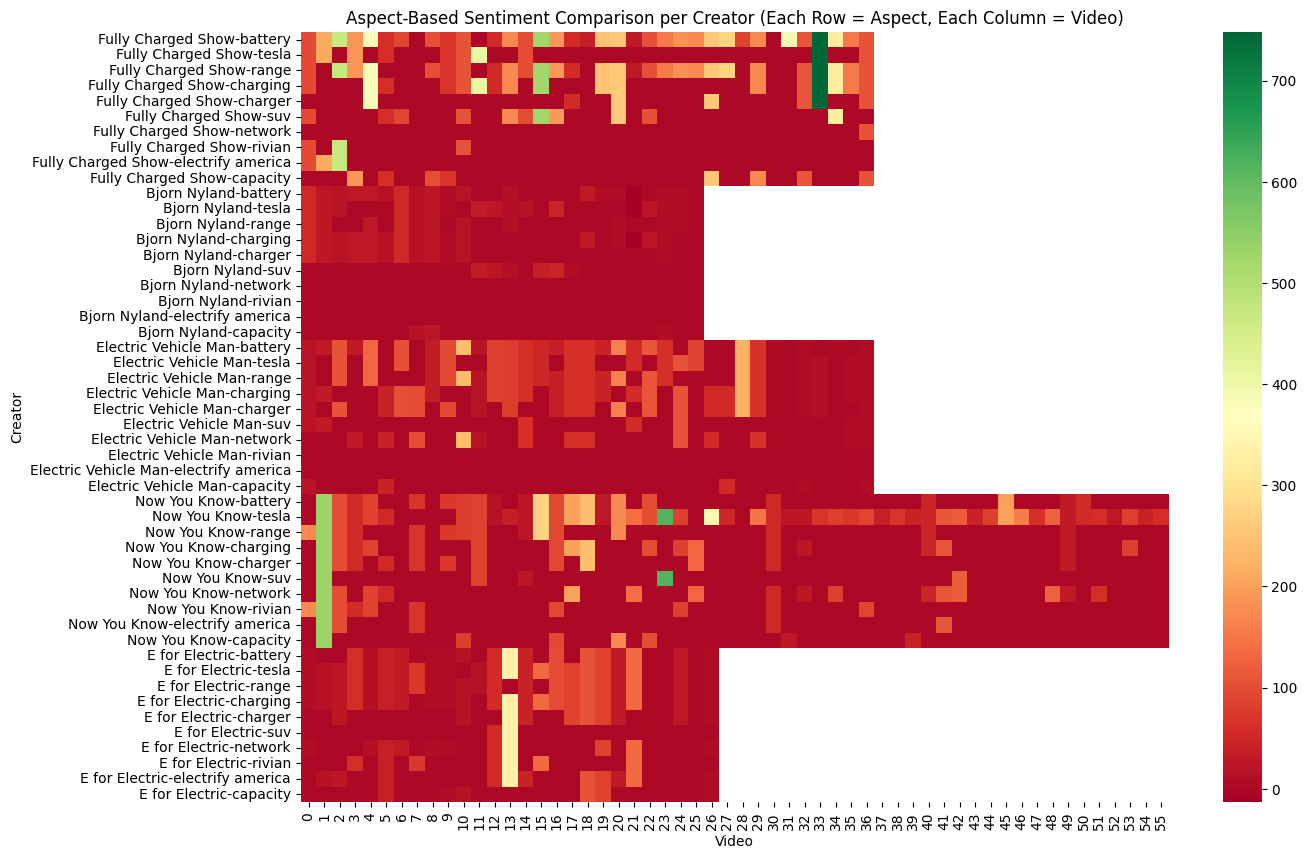

In [72]:
# Initialize the result list
topic_sentiment_matrix = []

# Loop through each creator
for creator in df["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df["video_id"].unique():
        video_comments = creator_df[creator_df["video_id"] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_topics}

        # Loop through each comment and its sentiment
        for aspects, sentiment in zip(video_comments["topics"], video_comments["sentiment_vader"]):
            if aspects in aspect_sentiments:  # Ensure aspect is one of the top extracted aspects
                # Increment or decrement based on sentiment
                aspect_sentiments[aspects] += (
                    1 if sentiment == "positive" else -1 if sentiment == "negative" else 0
                )

        # Append sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_topics])

    # Convert the list into a DataFrame for this creator and append to the result list
    creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_topics)
    topic_sentiment_matrix.append(creator_df_sentiment)

# Concatenate all creator sentiment matrices (horizontally) with labels
topic_sentiment_matrix = pd.concat(topic_sentiment_matrix, axis=1, keys=df["channel"].unique())

# Plot the overall aspect sentiment matrix
plt.figure(figsize=(14, 10))
sns.heatmap(topic_sentiment_matrix.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row = Aspect, Each Column = Video)")
plt.xlabel("Video")
plt.ylabel("Creator")
plt.show()


In [ ]:
topic_sentiment_matrix.to_csv("topic_sentiment_matrix_comparison_between_creators_vader.csv", index=True)

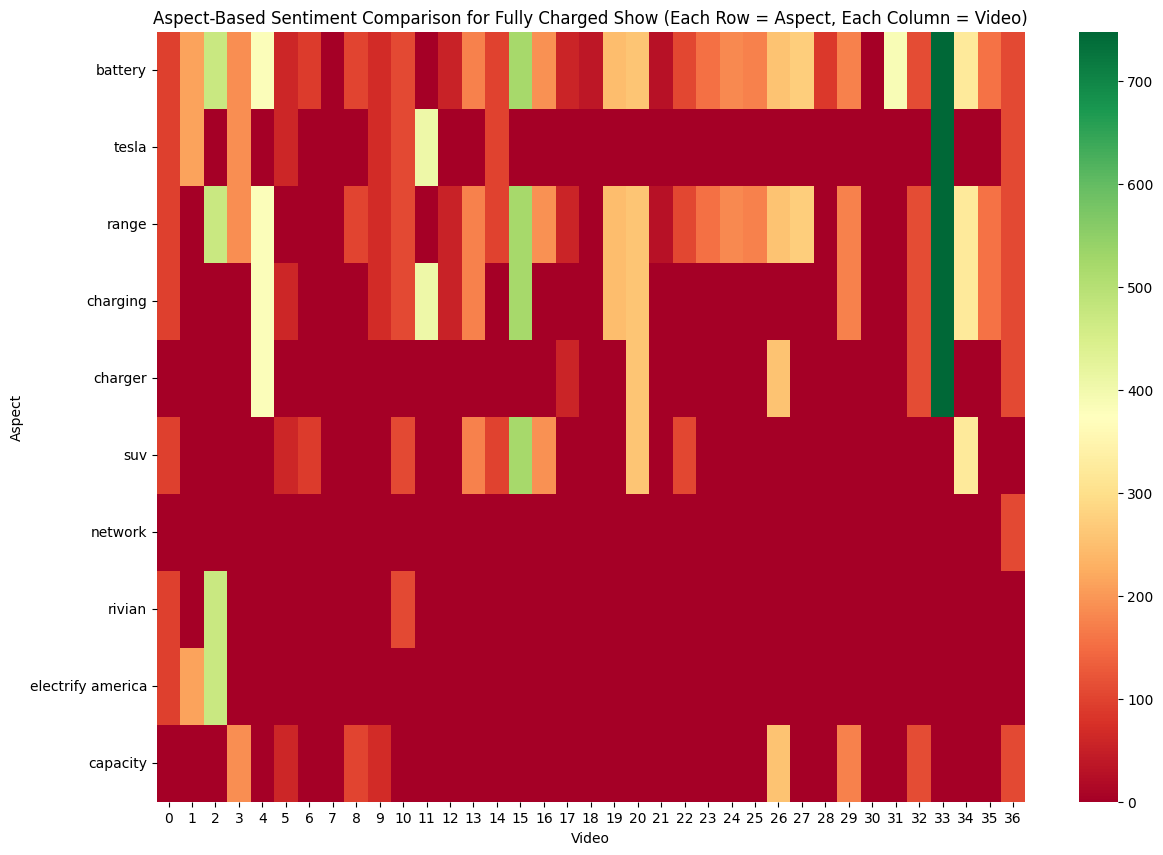

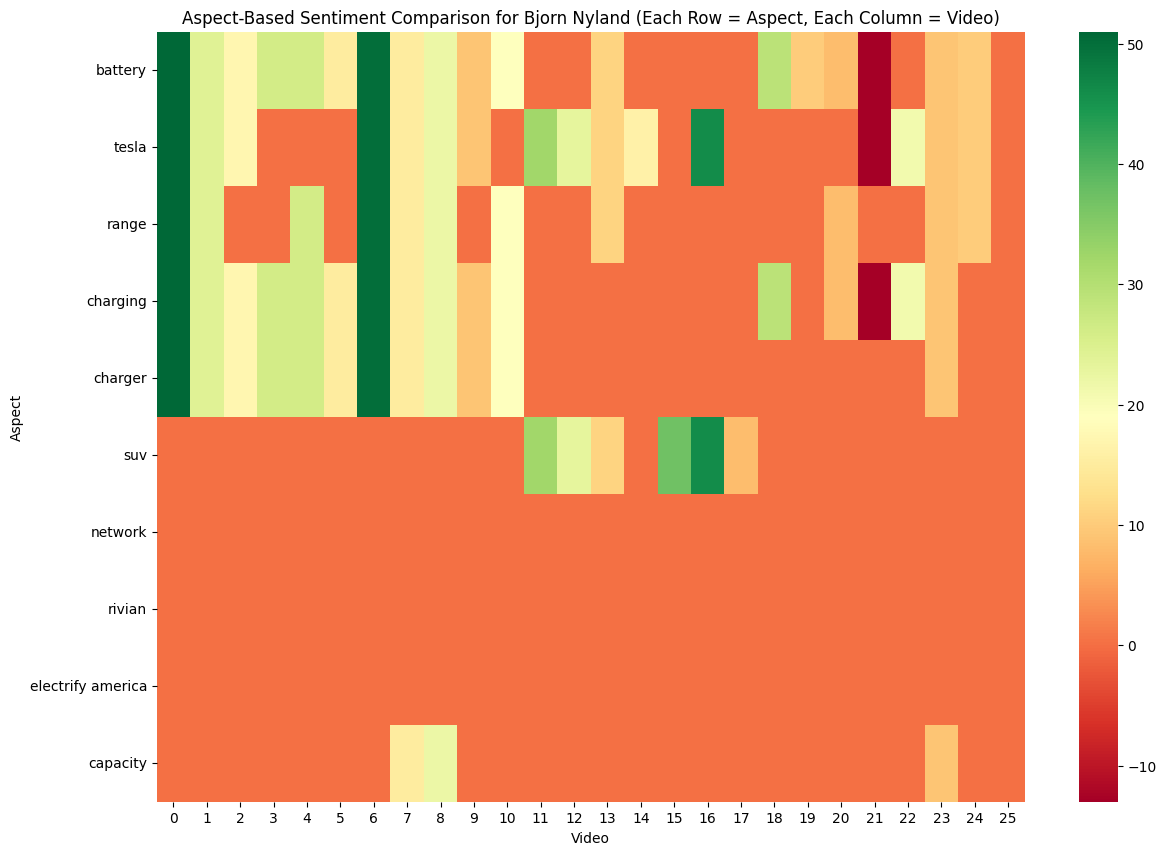

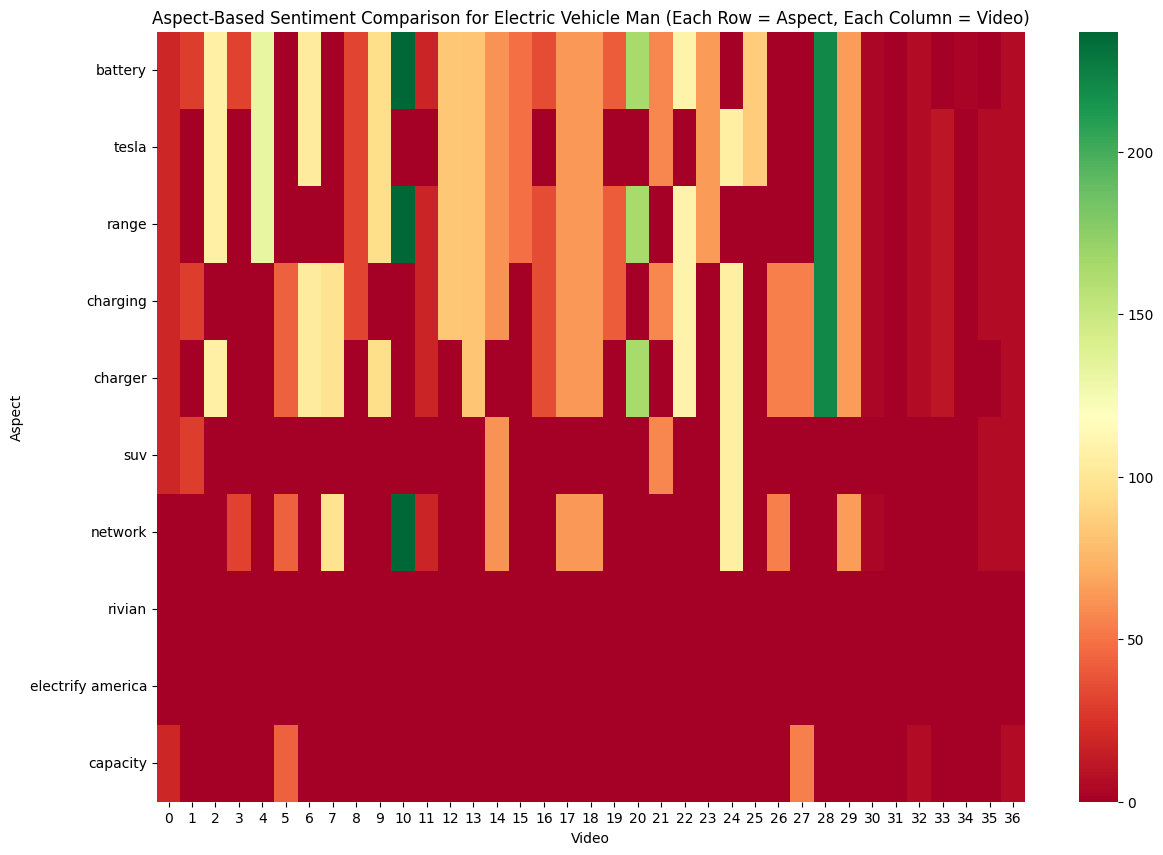

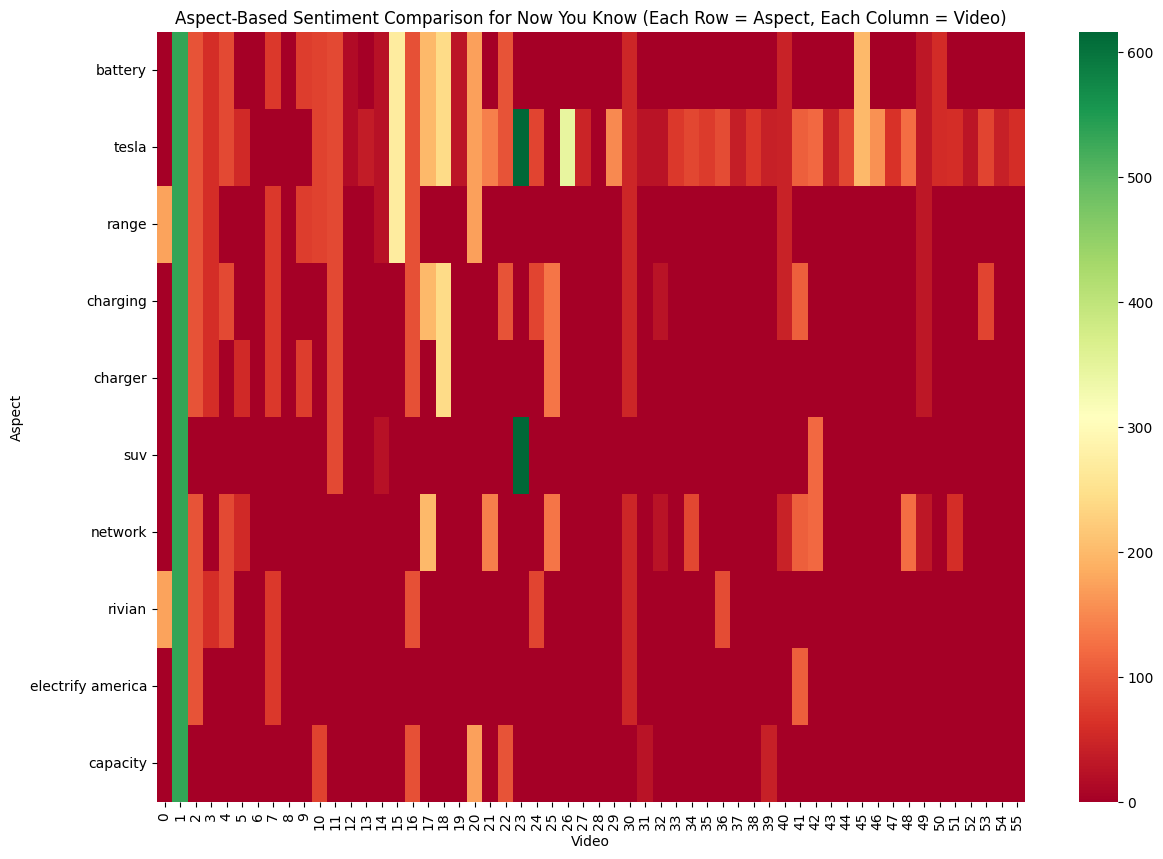

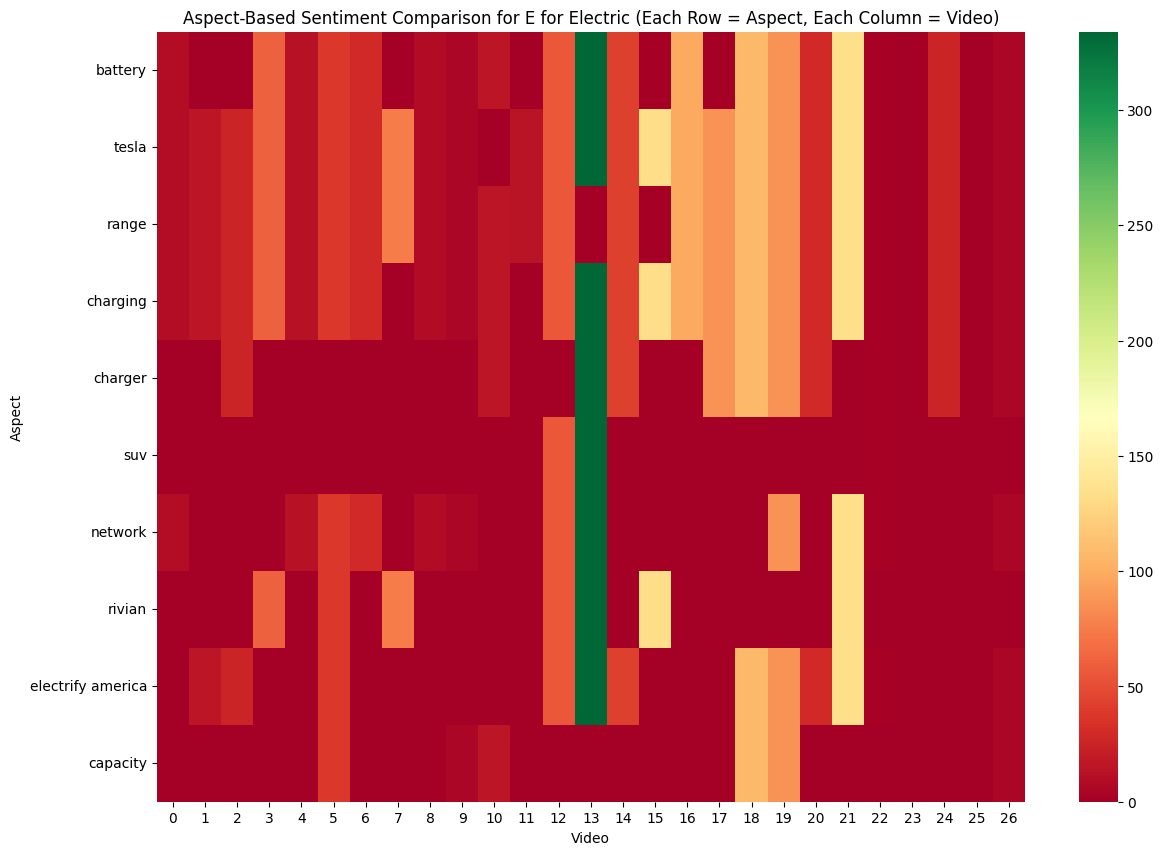

In [73]:
# Initialize the result list
topic_sentiment_matrix = []

# Loop through each creator
for creator in df["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df["video_id"].unique():
        video_comments = creator_df[creator_df["video_id"] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_topics}

        # Loop through each comment and its sentiment
        for aspects, sentiment in zip(video_comments["topics"], video_comments["sentiment_vader"]):
            if aspects in aspect_sentiments:  # Ensure aspect is one of the top extracted aspects
                # Increment or decrement based on sentiment
                aspect_sentiments[aspects] += (
                    1 if sentiment == "positive" else -1 if sentiment == "negative" else 0
                )

        # Append sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_topics])

    # Convert the list into a DataFrame for this creator and append to the result list
    creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_topics)
    topic_sentiment_matrix.append(creator_df_sentiment)

# Plot one heatmap per creator
for idx, creator in enumerate(df["channel"].unique()):
    creator_sentiment_df = topic_sentiment_matrix[idx]
    
    # Plot the aspect sentiment for this specific creator
    plt.figure(figsize=(14, 10))
    sns.heatmap(creator_sentiment_df.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
    plt.title(f"Aspect-Based Sentiment Comparison for {creator} (Each Row = Aspect, Each Column = Video)")
    plt.xlabel("Video")
    plt.ylabel("Aspect")
    plt.show()

In [ ]:
creator_df_sentiment.to_csv("TD_IDF_creator_df_sentiment_roberta.csv", index=True)

In [ ]:
creator_df_sentiment.to_csv("creator_df_sentiment_vader.csv", index=True)

C:\Users\koole\AppData\Local\Temp\ipykernel_3892\4105303425.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")


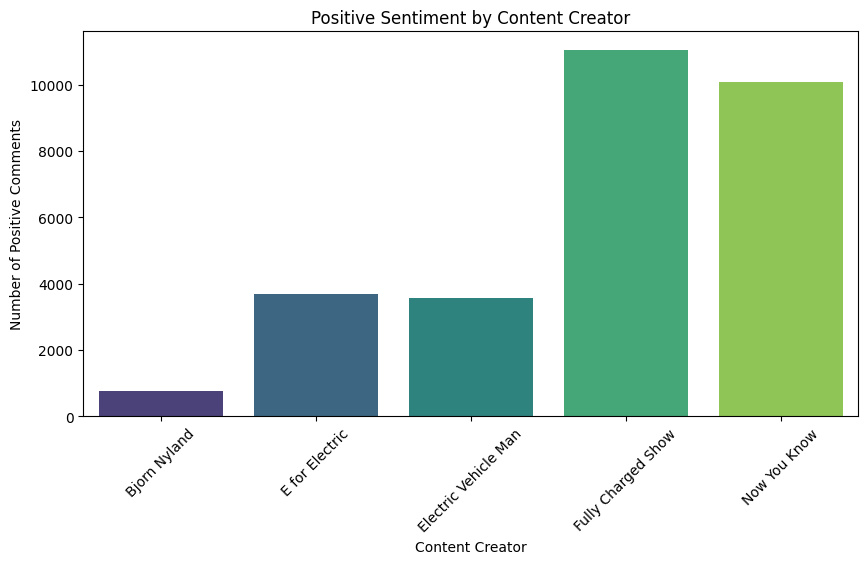

In [ ]:
# Count the number of positive comments per creator
positive_comments_per_creator = df[df['sentiment_vader'] == 'Positive'].groupby('channel').size()

# Plotting the number of positive comments per creator
plt.figure(figsize=(10, 5))
sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")
plt.title("Positive Sentiment by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.show()

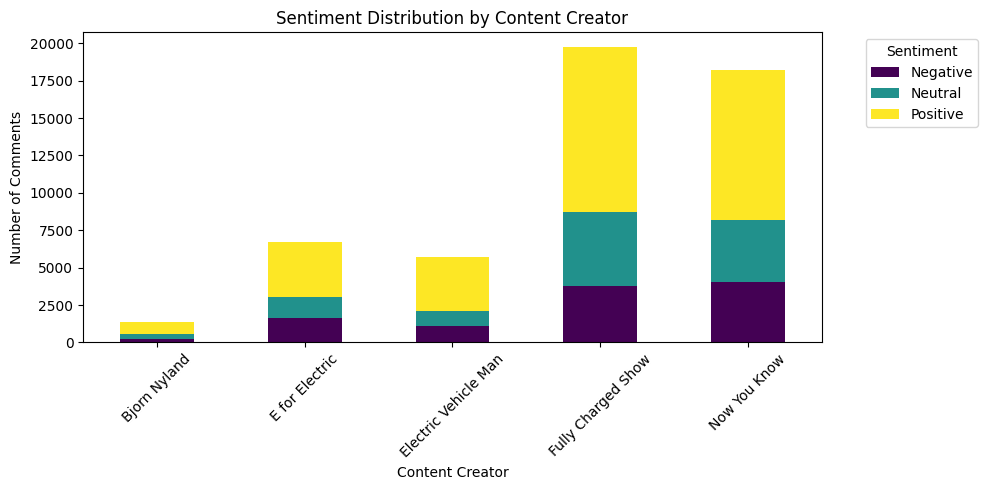

In [ ]:
# Count the number of comments per sentiment per creator
comments_per_creator_sentiment = df.groupby(['channel', 'sentiment_vader']).size().unstack(fill_value=0)

# Plotting the number of comments per sentiment (Positive, Negative, Neutral) per creator
comments_per_creator_sentiment.plot(kind='bar', stacked=True, figsize=(10, 5), colormap="viridis")

plt.title("Sentiment Distribution by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
comments_per_creator_sentiment.to_csv("comments_per_creator_sentiment_vader.csv", index=False)

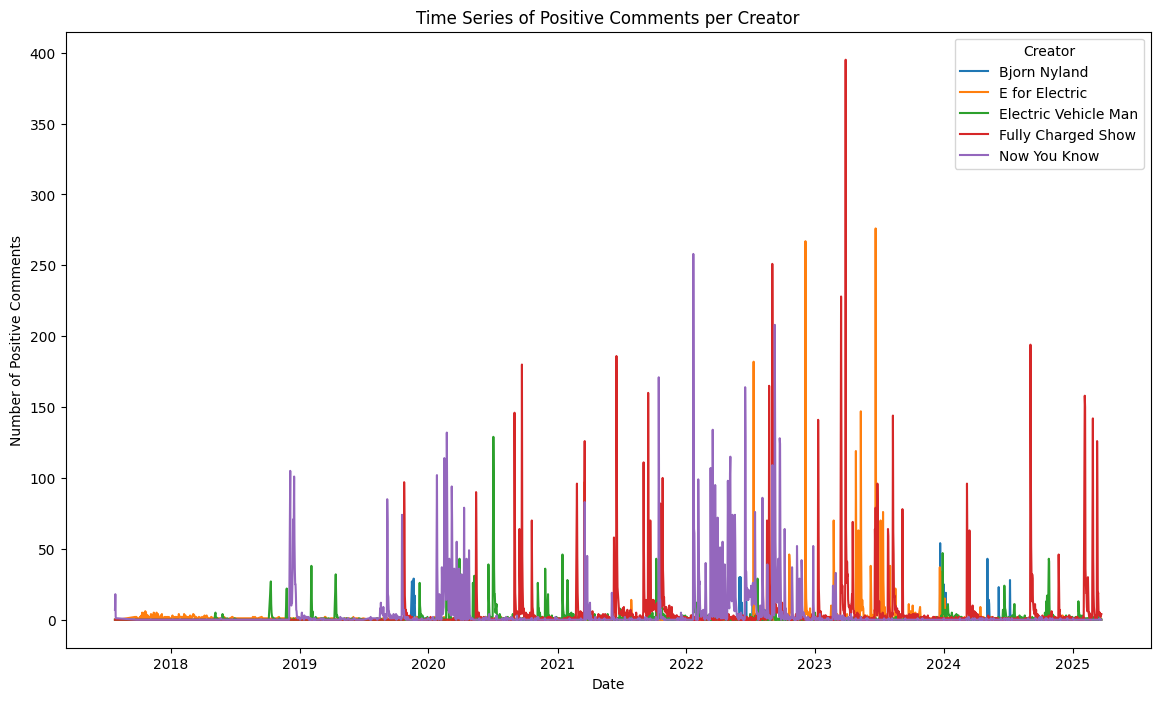

In [ ]:
# Time series of the number of positive comments received per creator
positive_comment_time_series = df[df['sentiment_vader'] == 'Positive'].groupby(['date', 'channel']).size().unstack(fill_value=0)
positive_comment_time_series.plot(figsize=(14, 8), title="Time Series of Positive Comments per Creator")
plt.ylabel('Number of Positive Comments')
plt.xlabel('Date')
plt.legend(title="Creator")
plt.show()

In [ ]:
positive_comment_time_series.to_csv("positive_comment_time_series_vader.csv", index=True)

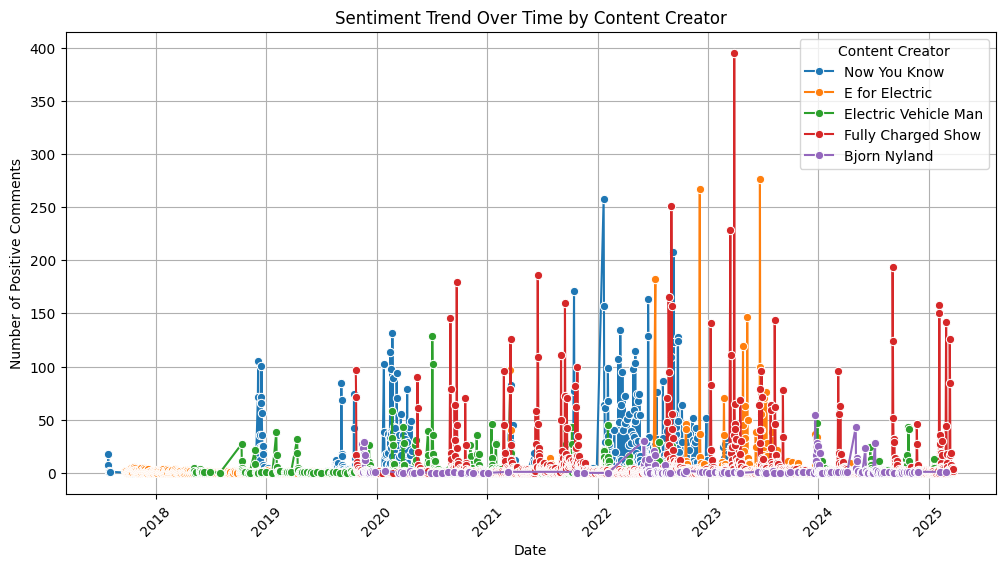

In [ ]:
# Sentiment Distribution per Aspect
aspect_sentiment = df.explode("topics").groupby(["topics", "sentiment_vader"]).size().unstack(fill_value=0)

# Compare Content Creators based on Sentiment
creator_sentiment = df.groupby(["channel", "sentiment_vader"]).size().unstack(fill_value=0)

# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Aggregate sentiment counts per date and channel
sentiment_counts = df.groupby(["date", "channel"])["sentiment_vader"].value_counts().unstack(fill_value=0).reset_index()

# Convert "date" back to datetime type
sentiment_counts["date"] = pd.to_datetime(sentiment_counts["date"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_counts, x="date", y="Positive", hue="channel", marker="o")

plt.title("Sentiment Trend Over Time by Content Creator")
plt.xlabel("Date")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.legend(title="Content Creator")
plt.grid()
plt.show()


# ROBERTA

In [120]:
# ROBERTA

# ABSA (Aspect Sentiment Aggregation)
def absa_by_topic(df):
    topic_sentiments = {}
    for _, row in df.iterrows():
        for topic in row["topics"]:
            if topic not in topic_sentiments:
                topic_sentiments[topic] = {"Positive": 0, "Negative": 0, "Neutral": 0}
            topic_sentiments[topic][row["sentiment_roberta"]] += 1
    return pd.DataFrame(topic_sentiments).T

absa_results_roberta = absa_by_topic(df)
print("\n--- ABSA by Topic ---")
print(absa_results_roberta)


--- ABSA by Topic ---
                     Positive  Negative  Neutral
horsepower               3558      1569     1710
ccs                      2589      1214      953
tesla                   16900      8398     6961
range                   16150      7360     6711
software update          1060       555      453
...                       ...       ...      ...
solid-state battery       113       109       60
lucid motors              113       109       60
nhtsa                     235       171       51
adas                      235       171       51
smart charging             45        19       23

[97 rows x 3 columns]


In [121]:
absa_results_roberta.head()

Positive  Negative  Neutral
horsepower           3558      1569     1710
ccs                  2589      1214      953
tesla               16900      8398     6961
range               16150      7360     6711
software update      1060       555      453

In [122]:
absa_results_roberta.to_csv("absa_results_roberta.csv", index=True)

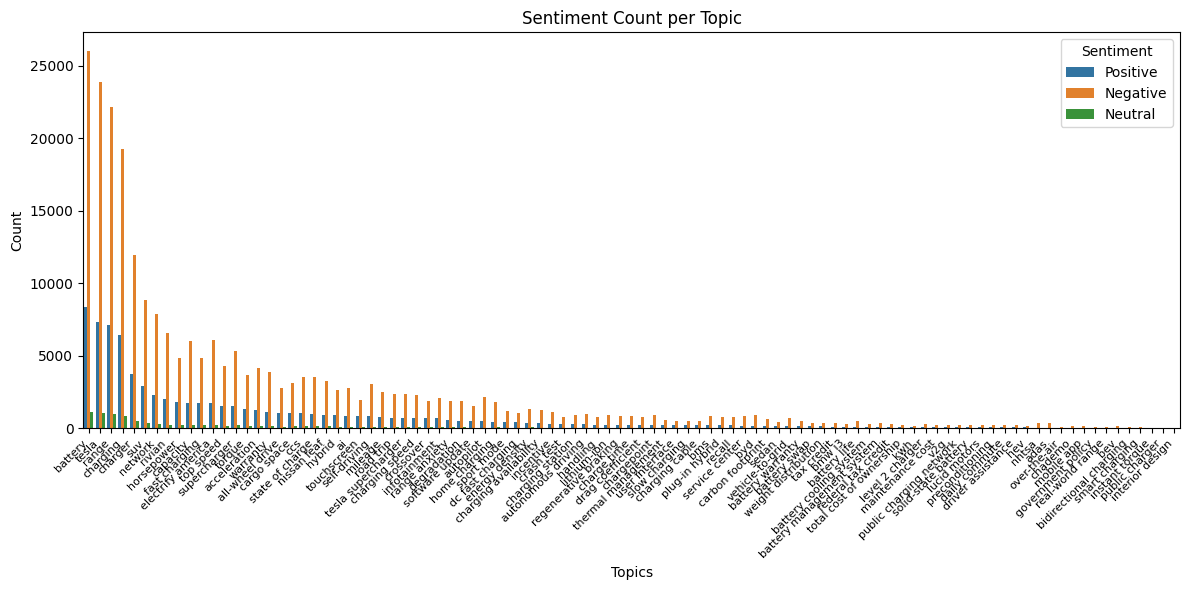

In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv(r"C:\Users\koole\Documents\9) PLP Practice Module\Use Topics\For Chen Jia\Topics As Aspects_Roberta_Vader\ROBERTA_topics_as_aspects\absa_results_roberta.csv")

# Optional: Sort topics for clarity
df = df.sort_values(by=["Positive", "Negative", "Neutral"], ascending=False)

# Melt the dataframe for easier plotting
df_melted = df.melt(id_vars="Topics", value_vars=["Positive", "Negative", "Neutral"],
                    var_name="Sentiment", value_name="Count")

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Topics", y="Count", hue="Sentiment")

plt.title("Sentiment Count per Topic")
plt.xticks(rotation=45, ha='right',fontsize=8)
plt.tight_layout()
plt.show()


In [125]:
df.columns

Index(['Topics', 'Positive', 'Negative', 'Neutral'], dtype='object')

In [126]:
df = pd.read_csv("comment_sentiment_roberta_FineTuning.csv")
# 3Aspect-Based Sentiment Comparison Among Creators
# Summarize sentiment distribution per creator
sentiment_counts = df.groupby(['channel', 'sentiment_roberta']).size().unstack(fill_value=0)
sentiment_counts = sentiment_counts[['Positive', 'Neutral', 'Negative']]  # Ensure the correct order

In [127]:
sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
sentiment_df.to_csv("roberta_sentiment_counts.csv", index=False)

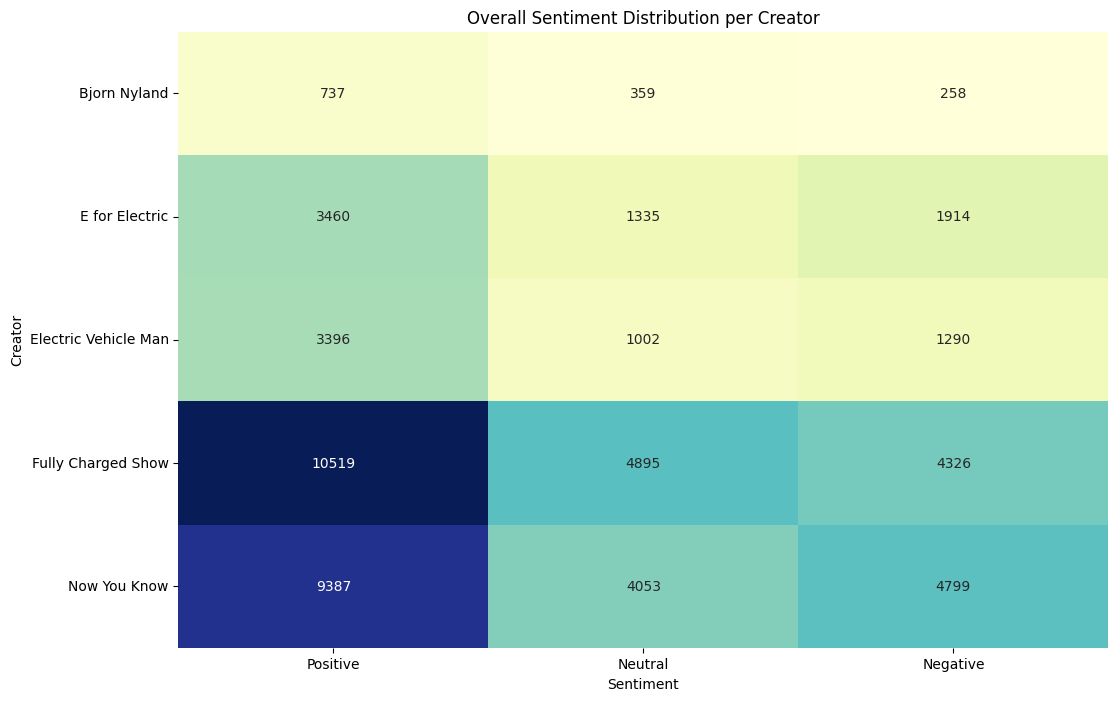

In [128]:
# Plot the heatmap for overall sentiment distribution per creator
plt.figure(figsize=(12, 8))
sns.heatmap(sentiment_counts, annot=True, cmap="YlGnBu", fmt="d", cbar=False)
plt.title('Overall Sentiment Distribution per Creator')
plt.xlabel('Sentiment')
plt.ylabel('Creator')
plt.show()

C:\Users\koole\AppData\Local\Temp\ipykernel_25872\1817992175.py:60: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


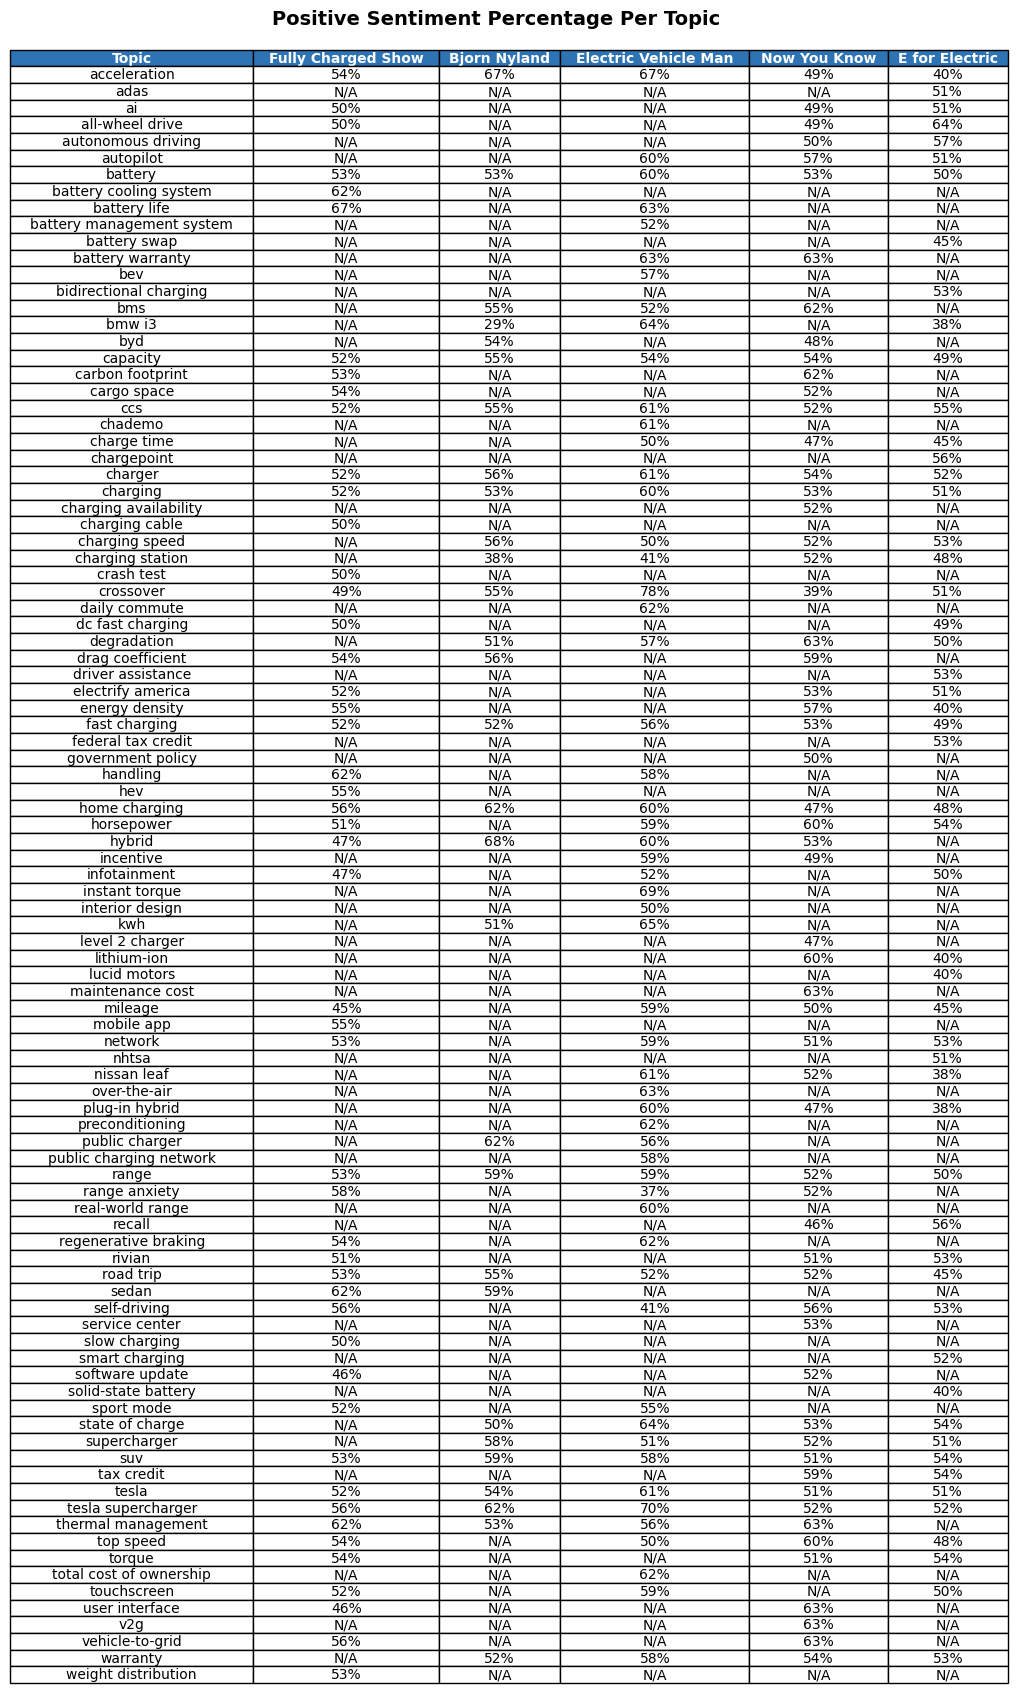

In [79]:
from itertools import chain

# Flatten the list of lists and get unique topics
all_topics = set(chain.from_iterable(df["topics"]))
top_topics_df = pd.DataFrame(sorted(all_topics), columns=["Topic"])

# Initialize dictionary to store sentiment counts per creator
sentiment_counts = {topic: {} for topic in top_topics_df["Topic"]}

# Process sentiment data
for creator in df["channel"].unique():
    creator_df = df[df["channel"] == creator]
    
    for topic in top_topics_df["Topic"]:
        total_mentions = 0
        positive_mentions = 0
        
        for topics, sentiment in zip(creator_df["topics"], creator_df["sentiment_roberta"]):
            if topic in topics:  # ✅ Check if the topic is in the list
                total_mentions += 1
                if str(sentiment).strip().lower() == "positive":
                    positive_mentions += 1
        
        sentiment_counts[topic][creator] = (
            f"{(positive_mentions / total_mentions * 100):.0f}%" if total_mentions > 0 else "N/A"
        )


# Convert sentiment data to DataFrame
sentiment_df = pd.DataFrame(sentiment_counts).T.reset_index()
sentiment_df.columns = ["Topic"] + list(df["channel"].unique())

# Plot the Table
fig, ax = plt.subplots(figsize=(10, 4))

# Hide axes
ax.axis("tight")
ax.axis("off")

# Create the table
table = ax.table(cellText=sentiment_df.values, 
                 colLabels=sentiment_df.columns, 
                 cellLoc="center", 
                 loc="center")

# Style the Table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width([i for i in range(len(sentiment_df.columns))])

# Highlight header row
for key, cell in table.get_celld().items():
    if key[0] == 0:  # Header row
        cell.set_text_props(weight="bold", color="white")
        cell.set_facecolor("#2E74B5")  # Blue Header

# Add title above the table using fig.text
fig.text(0.5, 2.6, "Positive Sentiment Percentage Per Topic", fontsize=14, weight="bold", ha="center")

plt.tight_layout()
plt.show()

In [80]:
sentiment_df.head()
sentiment_df.to_csv("topic_sentiment_summary_roberta.csv", index=False)

<Figure size 1800x600 with 0 Axes>

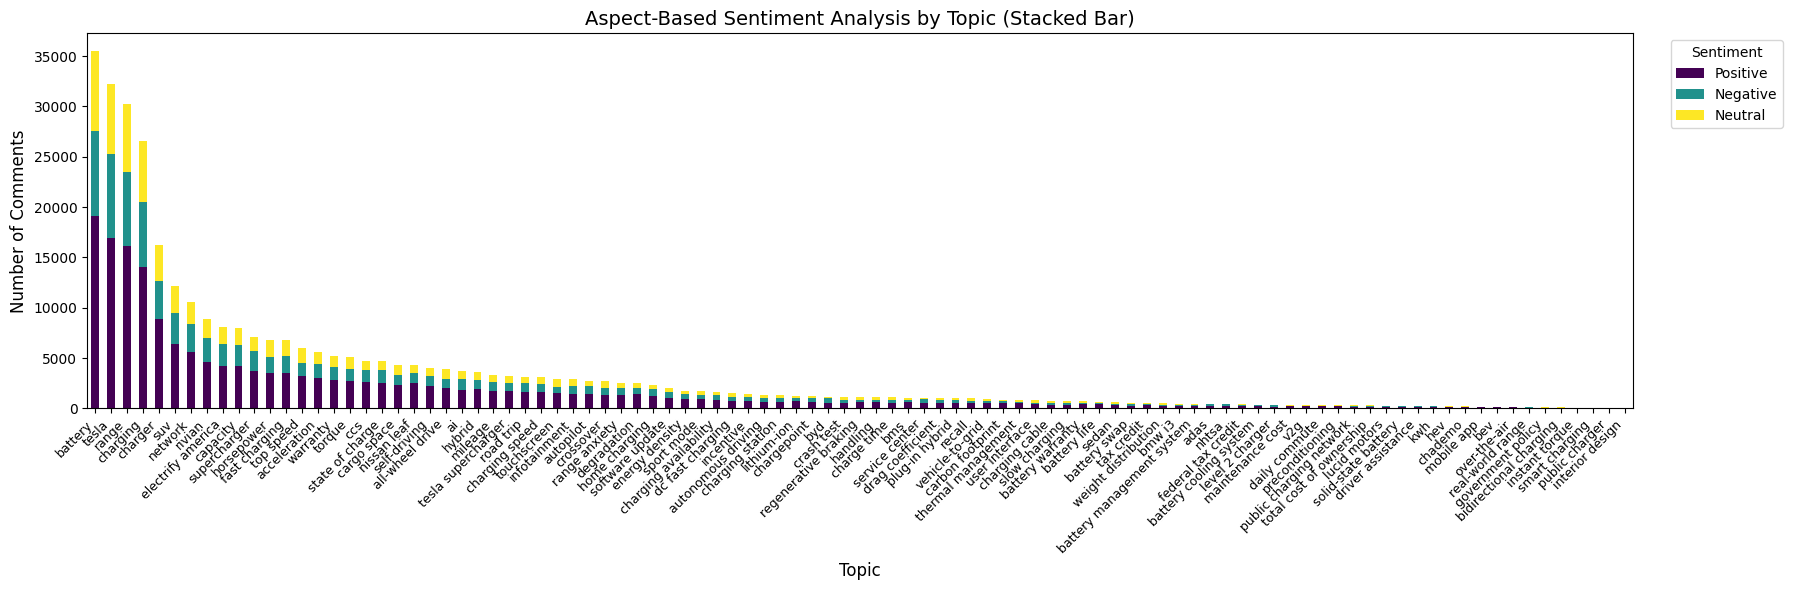

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare data
absa_results_plot = absa_results_roberta.copy()
absa_results_plot["Total"] = absa_results_plot.sum(axis=1)
absa_results_plot = absa_results_plot.sort_values("Total", ascending=False).drop("Total", axis=1)

# Increase figure width and reduce font size
plt.figure(figsize=(18, 6))  # wider figure
ax = absa_results_plot.plot(kind="bar", stacked=True, colormap="viridis", figsize=(18, 6))

plt.title("Aspect-Based Sentiment Analysis by Topic (Stacked Bar)", fontsize=14)
plt.ylabel("Number of Comments", fontsize=12)
plt.xlabel("Topic", fontsize=12)

# Shrink and rotate x-axis labels
plt.xticks(rotation=45, ha="right", fontsize=9)

# Adjust legend
plt.legend(title="Sentiment", bbox_to_anchor=(1.02, 1), loc='upper left')
plt.tight_layout()
plt.show()


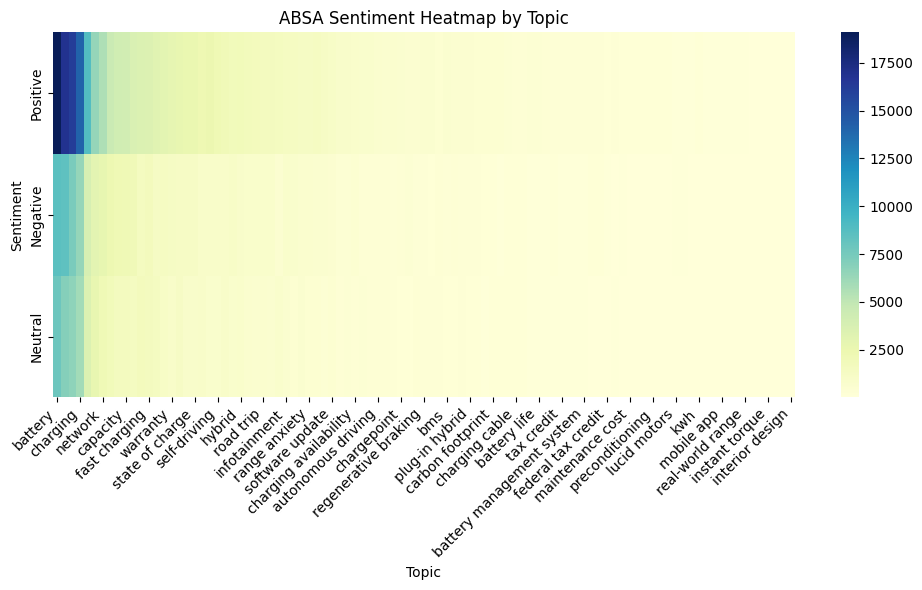

In [82]:
# ROBERTA
# Plot: Heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(absa_results_plot.T, annot=False, fmt='d', cmap="YlGnBu")
plt.title("ABSA Sentiment Heatmap by Topic")
plt.ylabel("Sentiment")
plt.xlabel("Topic")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

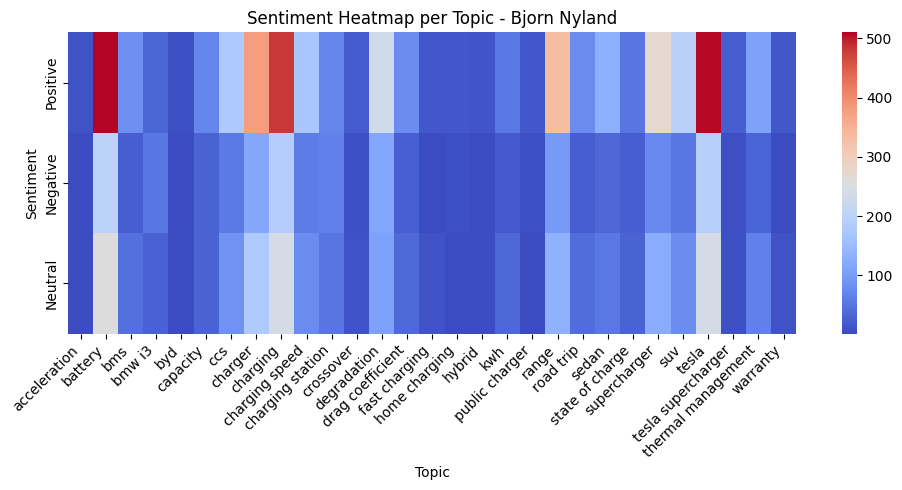

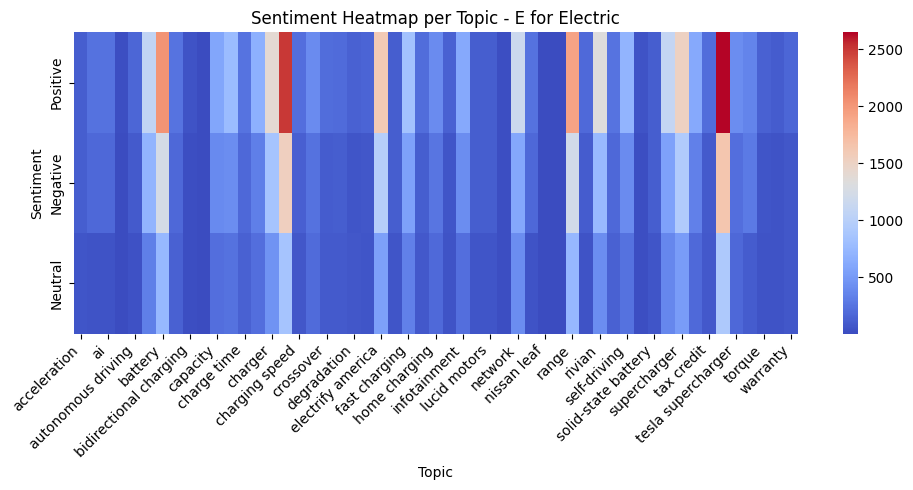

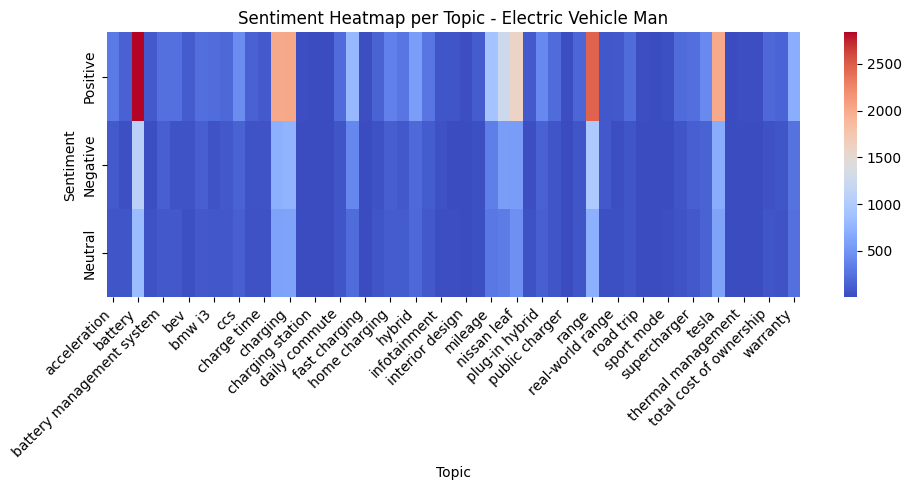

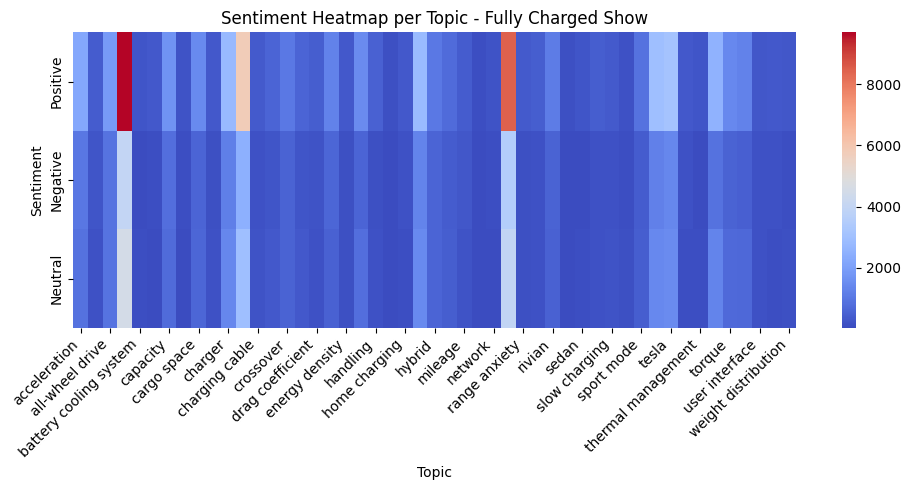

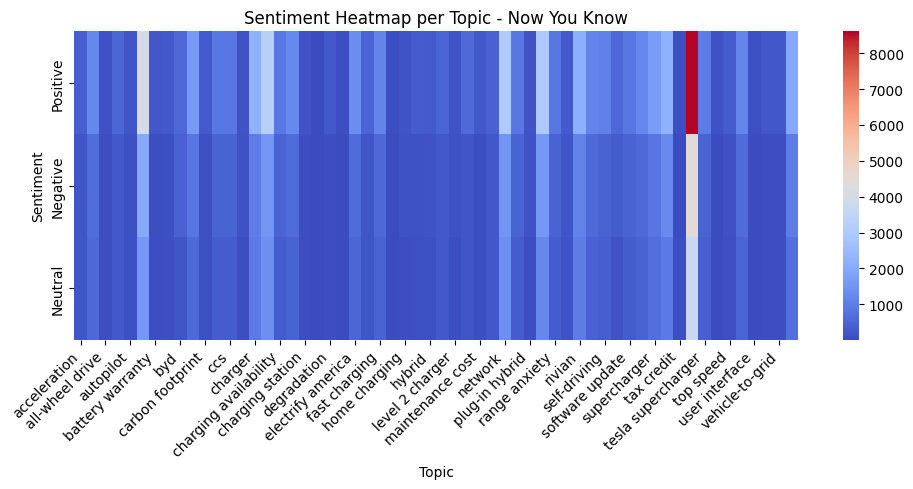

In [116]:
# ROBERTA

# ABSA heatmap per channel
df_expanded = df.explode("topics")
grouped = df_expanded.groupby(["channel", "topics", "sentiment_roberta"]).size().unstack(fill_value=0).reset_index()

for channel in grouped["channel"].unique():
    subset = grouped[grouped["channel"] == channel].set_index("topics")[["Positive", "Negative", "Neutral"]]
    plt.figure(figsize=(10, 5))
    sns.heatmap(subset.T, annot=False, fmt="d", cmap="coolwarm")
    plt.title(f"Sentiment Heatmap per Topic - {channel}")
    plt.ylabel("Sentiment")
    plt.xlabel("Topic")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

In [86]:
grouped.to_csv("topic_sentiment_per_creator_roberta.csv", index=True)

C:\Users\koole\AppData\Local\Temp\ipykernel_3892\80756993.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")


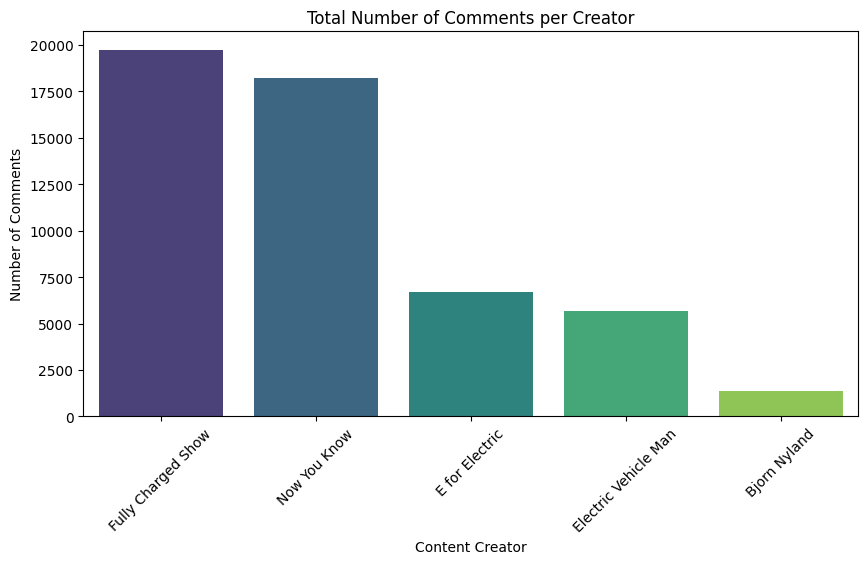

In [ ]:
total_comments = df["channel"].value_counts()
plt.figure(figsize=(10, 5))
sns.barplot(x=total_comments.index, y=total_comments.values, palette="viridis")
plt.title("Total Number of Comments per Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.show()

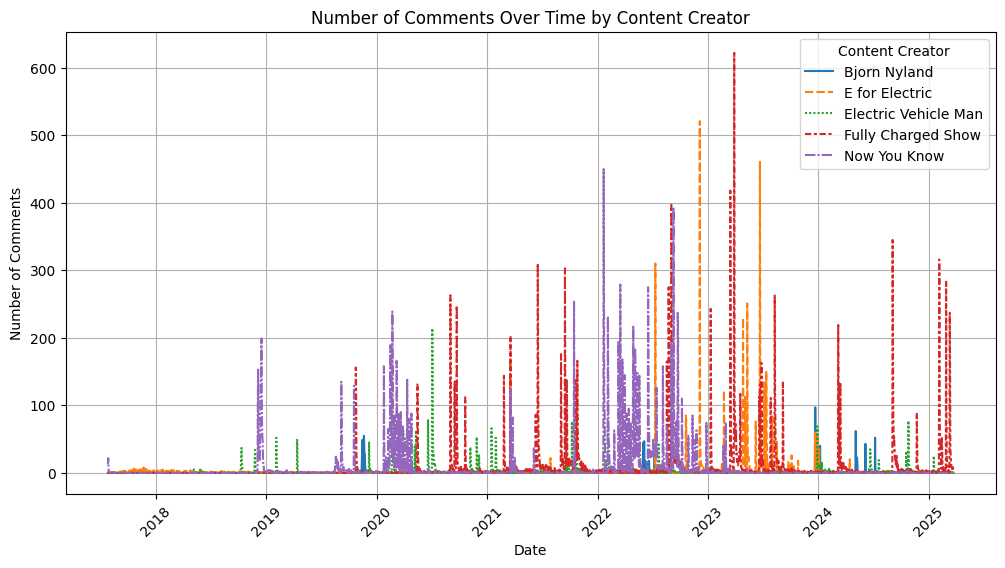

In [ ]:
# Time series of the number of comments received per creator
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date

comment_time_series = df.groupby(["date", "channel"]).size().unstack(fill_value=0)
plt.figure(figsize=(12, 6))
sns.lineplot(data=comment_time_series)
plt.title("Number of Comments Over Time by Content Creator")
plt.xlabel("Date")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Content Creator")
plt.grid()
plt.show()

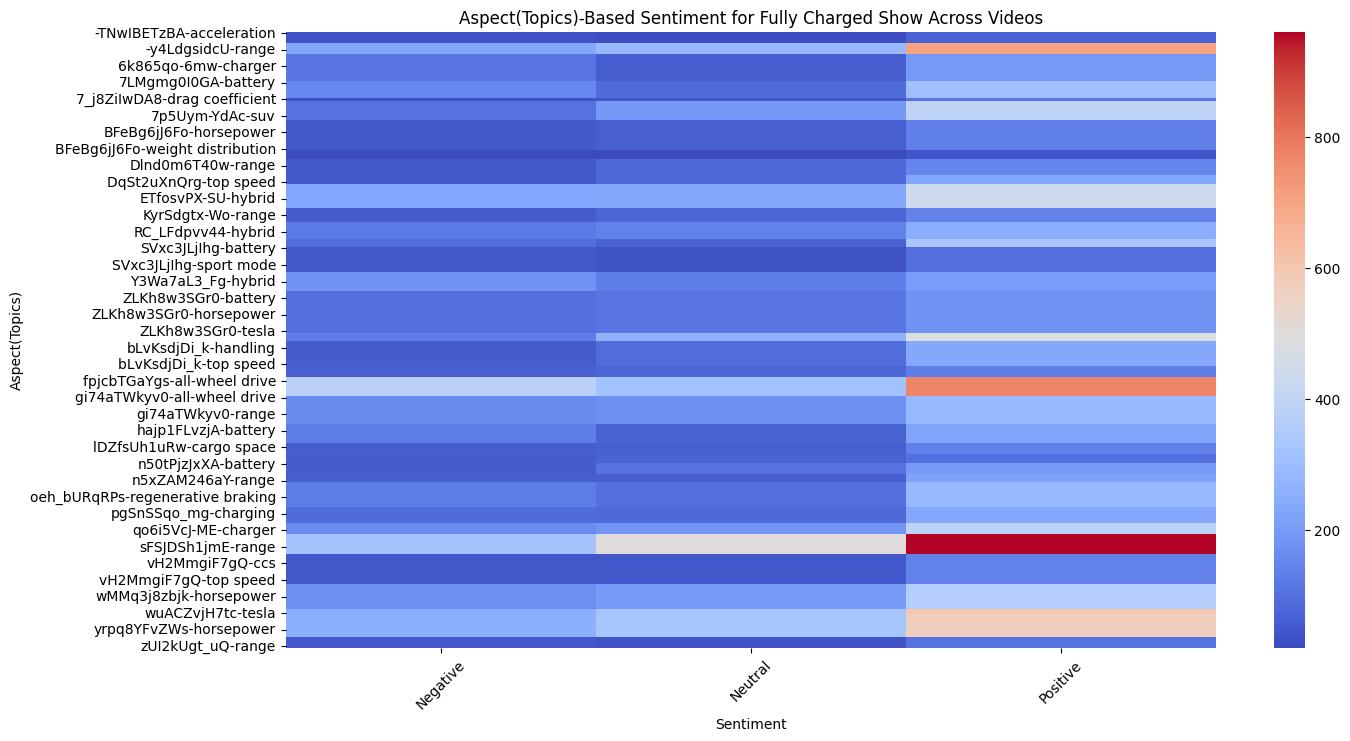

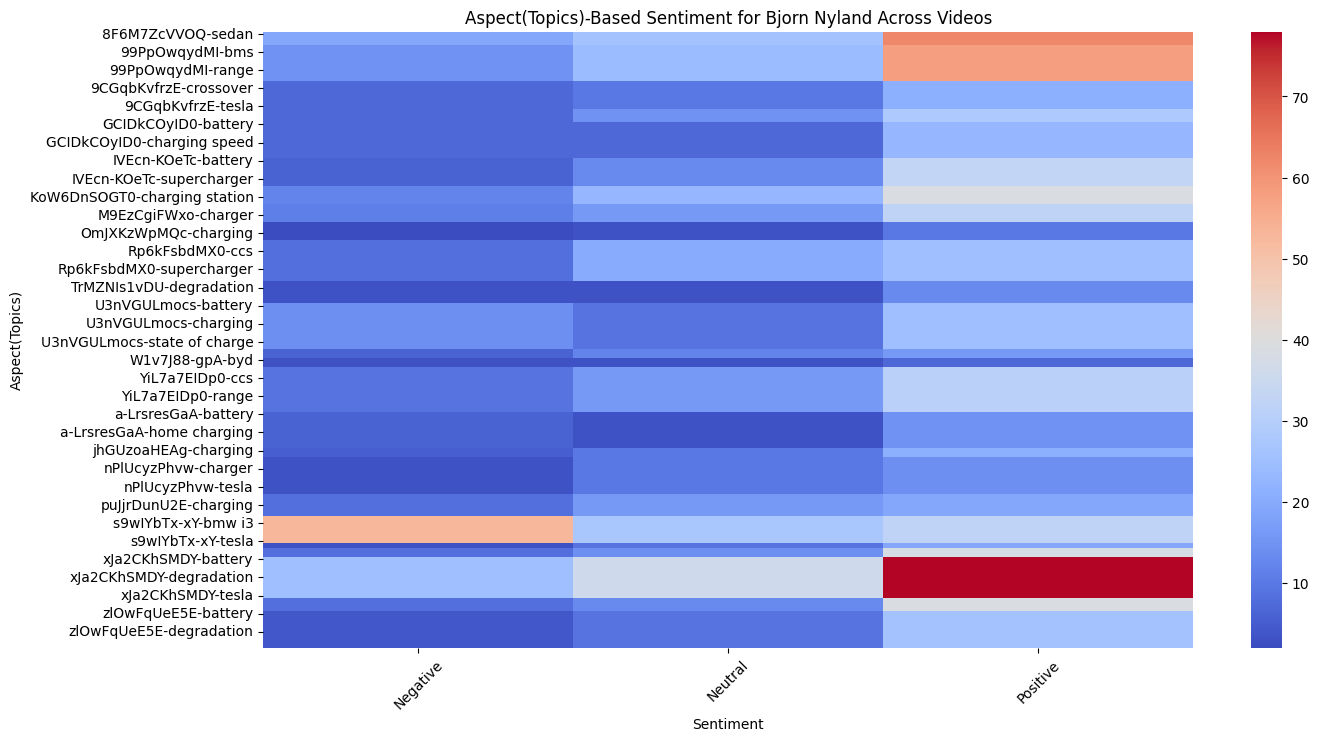

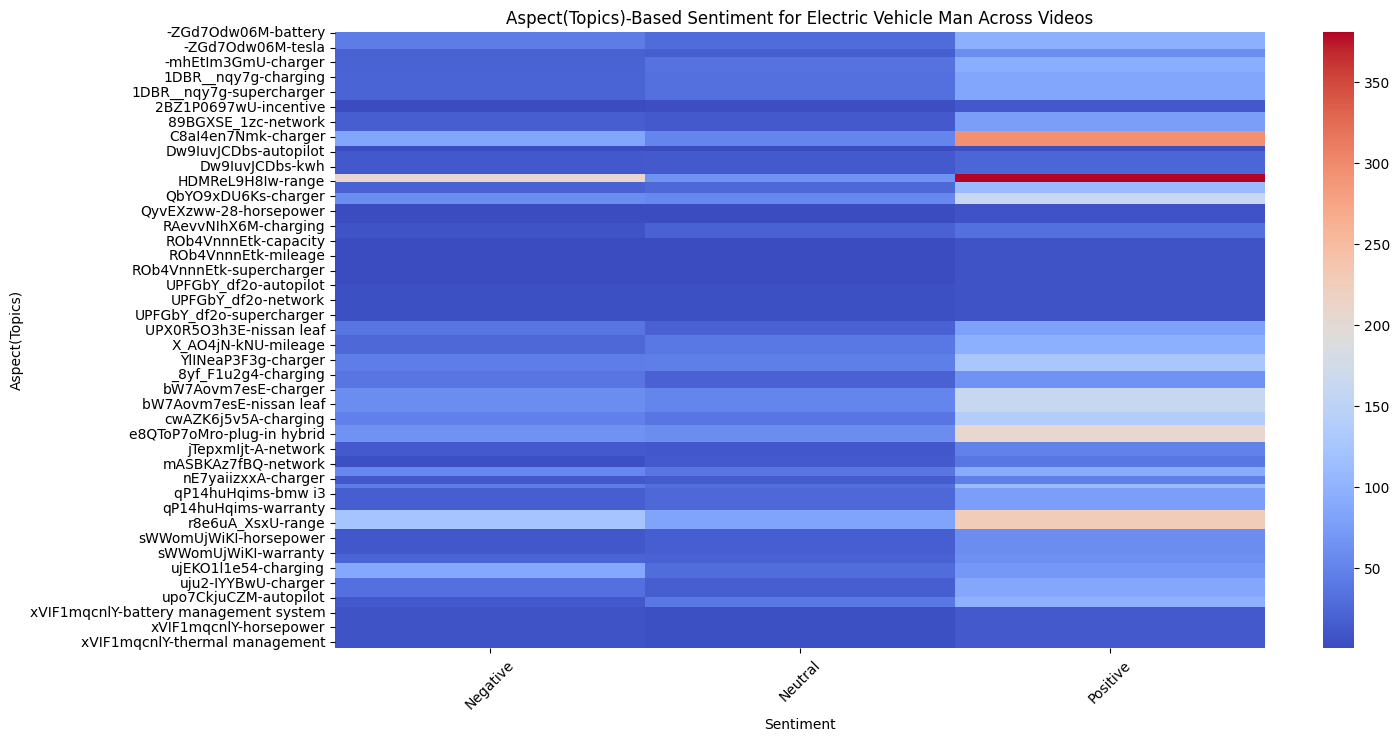

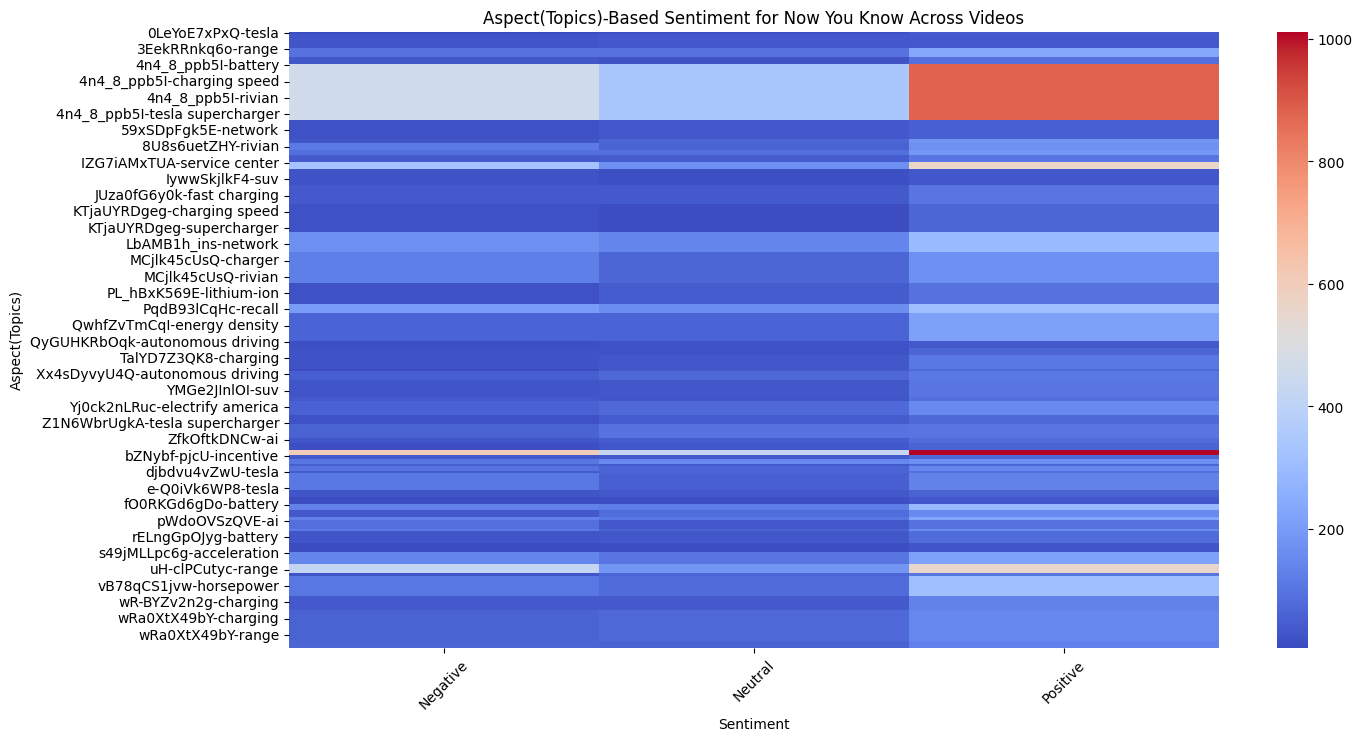

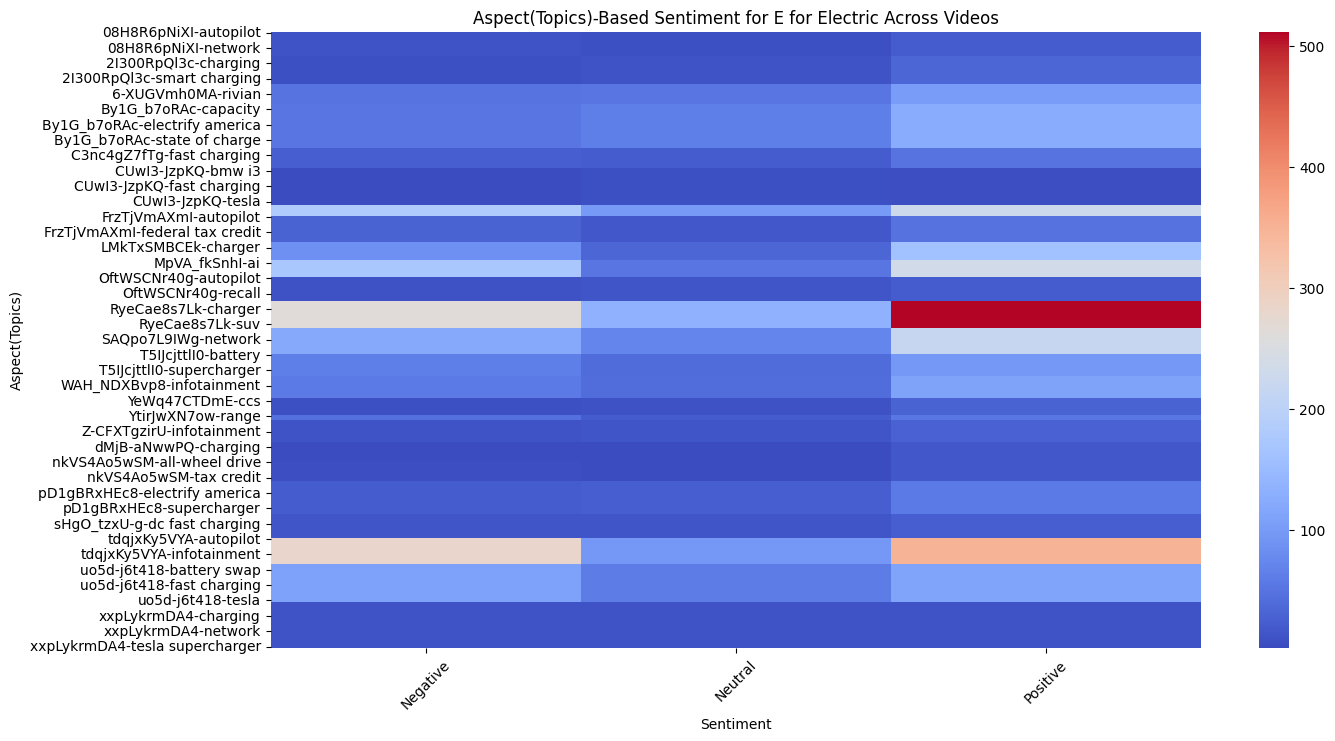

In [87]:
for creator in df["channel"].unique():
    creator_df = df[df["channel"] == creator].explode("topics")
    aspect_video_sentiment = creator_df.groupby(["video_id", "topics", "sentiment_roberta"]).size().unstack(fill_value=0)
    plt.figure(figsize=(15, 8))
    #sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=True, fmt="d")
    sns.heatmap(aspect_video_sentiment, cmap="coolwarm", annot=False, fmt="d")
    plt.title(f"Aspect(Topics)-Based Sentiment for {creator} Across Videos")
    plt.xlabel("Sentiment")
    plt.ylabel("Aspect(Topics)")
    plt.xticks(rotation=45)
    plt.show()

In [88]:
aspect_video_sentiment.head()

sentiment_roberta             Negative  Neutral  Positive
video_id    topics                                       
08H8R6pNiXI autopilot               11        8        22
            battery                 11        8        22
            charging                11        8        22
            crossover               11        8        22
            dc fast charging        11        8        22

In [89]:
aspect_video_sentiment.to_csv("aspect_video_sentiment_roberta.csv", index=True)

In [ ]:
import ast
df["topics"] = df["topics"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

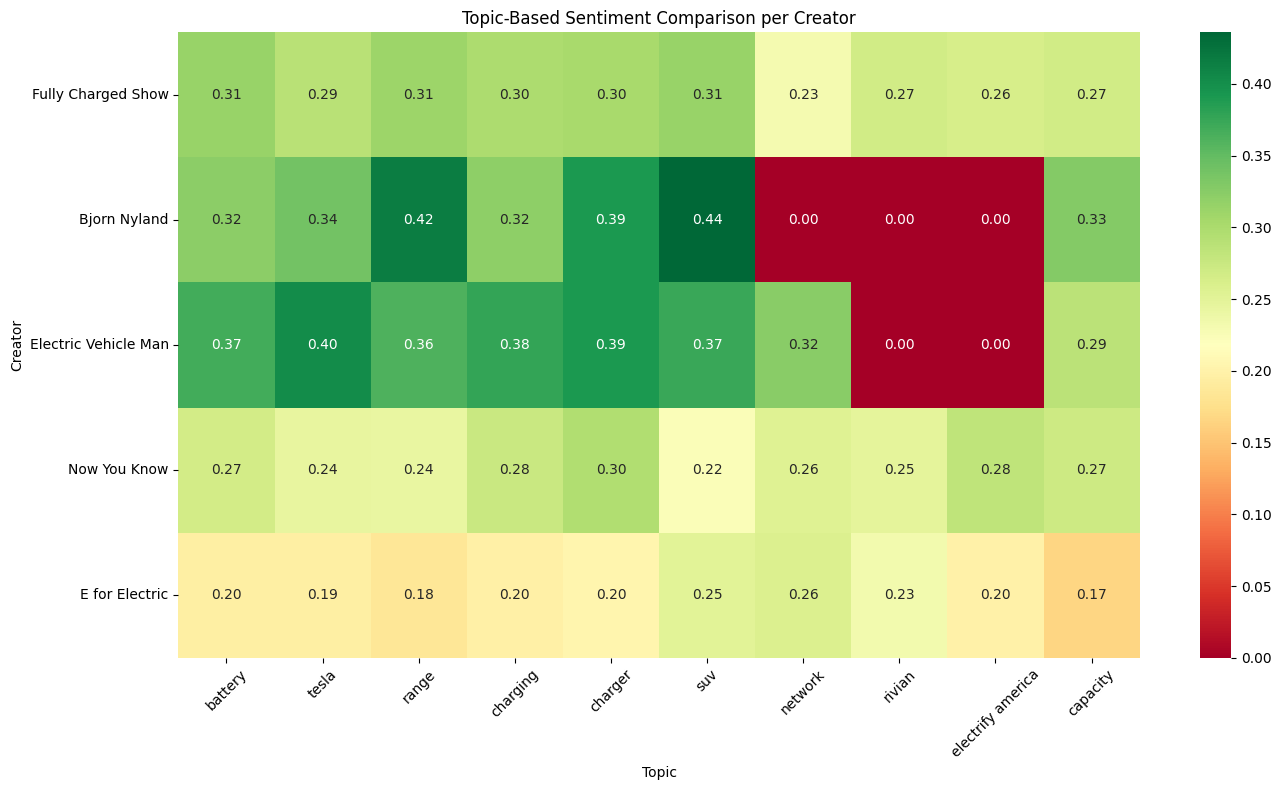

In [138]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explode topics column
df_exploded = df.explode("topics")

# Optional: standardize sentiment labels
df_exploded["sentiment_roberta"] = df_exploded["sentiment_roberta"].str.strip().str.lower()

# Get top N topics
top_topics = df_exploded["topics"].value_counts().head(10).index.tolist()

# Initialize the result matrix
topic_sentiment_matrix = pd.DataFrame()

# Loop through creators
for creator in df_exploded["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    
    # Initialize topic sentiment dict
    topic_scores = {topic: 0 for topic in top_topics}
    topic_counts = {topic: 0 for topic in top_topics}

    # Iterate rows
    for _, row in creator_df.iterrows():
        topic = row["topics"]
        sentiment = row["sentiment_roberta"]
        if topic in top_topics:
            if sentiment == "positive":
                topic_scores[topic] += 1
            elif sentiment == "negative":
                topic_scores[topic] -= 1
            topic_counts[topic] += 1

    # Normalize scores
    topic_sentiment_avg = {
        topic: (topic_scores[topic] / topic_counts[topic]) if topic_counts[topic] > 0 else 0
        for topic in top_topics
    }

    topic_sentiment_matrix[creator] = pd.Series(topic_sentiment_avg)

# Plot the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(topic_sentiment_matrix.T, annot=True, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Topic-Based Sentiment Comparison per Creator")
plt.xlabel('Topic')
plt.ylabel('Creator')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [139]:
# Save the aspect sentiment matrix to CSV
topic_sentiment_matrix.T.to_csv("Topics_aspect_sentiment_per_creator_roberta.csv", index=True)

In [91]:
topic_sentiment_matrix.head()

Fully Charged Show  Bjorn Nyland  Electric Vehicle Man  \
battery             0.313425      0.321946              0.369208   
tesla               0.288641      0.339744              0.402719   
range               0.311160      0.416667              0.361286   
charging            0.298655      0.321625              0.376846   
charger             0.301700      0.390208              0.390925   

          Now You Know  E for Electric  
battery       0.266605        0.195761  
tesla         0.244288        0.194578  
range         0.243182        0.184340  
charging      0.275412        0.195914  
charger       0.296013        0.202877

In [92]:
topic_sentiment_matrix.to_csv("topic_sentiment_matrix_roberta.csv", index=False)

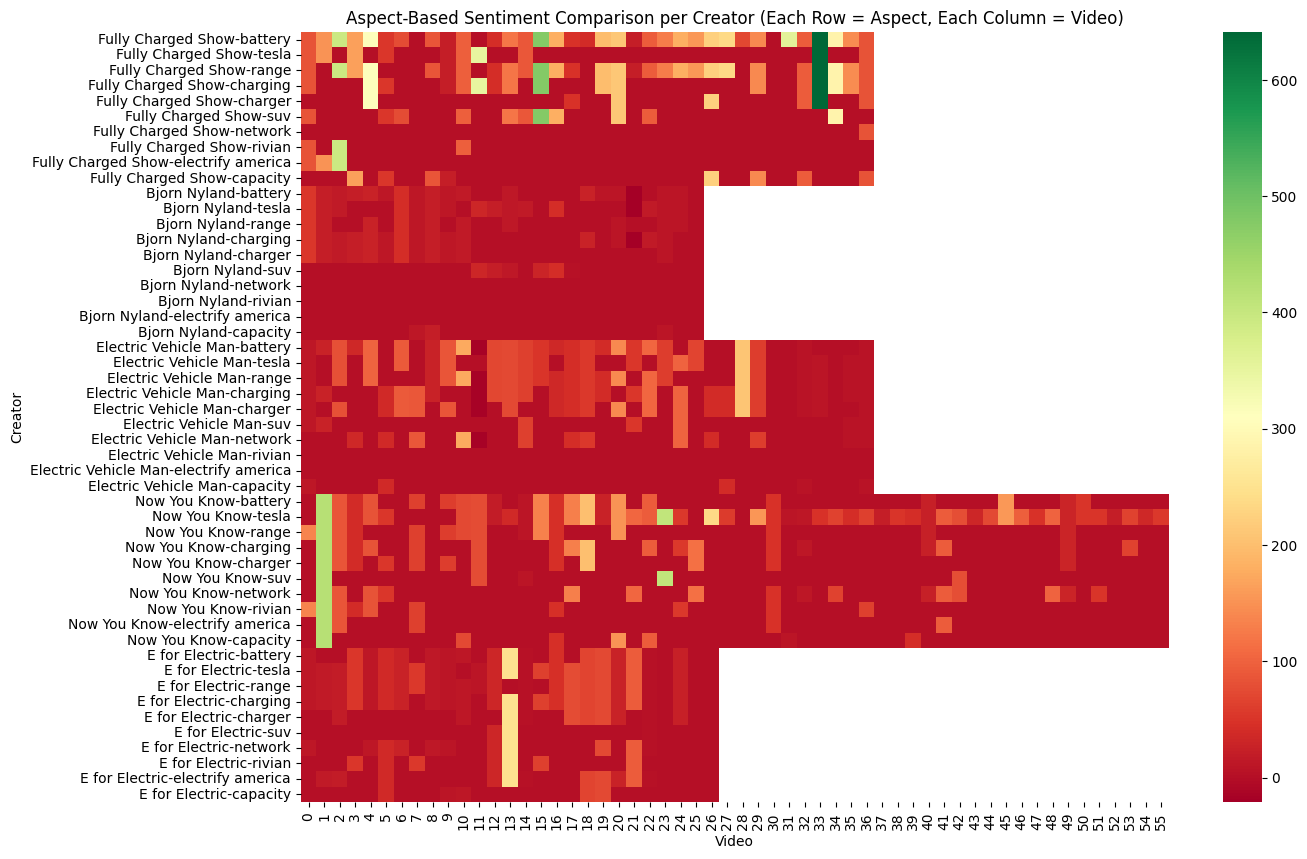

In [135]:
df["topics"] = df["topics"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Explode topics column
df_exploded = df.explode("topics")

# Optional: standardize sentiment labels
df_exploded["sentiment_roberta"] = df_exploded["sentiment_roberta"].str.strip().str.lower()

# Get top N topics
top_topics = df_exploded["topics"].value_counts().head(10).index.tolist()

# Initialize the result list
topic_sentiment_matrix = []

# Loop through each creator
for creator in df["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df["video_id"].unique():
        video_comments = creator_df[creator_df["video_id"] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_topics}

        # Loop through each comment and its sentiment
        for aspects, sentiment in zip(video_comments["topics"], video_comments["sentiment_roberta"]):
            if aspects in aspect_sentiments:  # Ensure aspect is one of the top extracted aspects
                # Increment or decrement based on sentiment
                aspect_sentiments[aspects] += (
                    1 if sentiment == "positive" else -1 if sentiment == "negative" else 0
                )

        # Append sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_topics])

    # Convert the list into a DataFrame for this creator and append to the result list
    creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_topics)
    topic_sentiment_matrix.append(creator_df_sentiment)

# Concatenate all creator sentiment matrices (horizontally) with labels
topic_sentiment_matrix = pd.concat(topic_sentiment_matrix, axis=1, keys=df["channel"].unique())

# Plot the overall aspect sentiment matrix
plt.figure(figsize=(14, 10))
sns.heatmap(topic_sentiment_matrix.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
plt.title("Aspect-Based Sentiment Comparison per Creator (Each Row = Aspect, Each Column = Video)")
plt.xlabel("Video")
plt.ylabel("Creator")
plt.show()


In [94]:
topic_sentiment_matrix.head()

Fully Charged Show                                                      \
             battery  tesla  range charging charger   suv network rivian   
0               84.0   84.0   84.0     84.0     0.0  84.0     0.0   84.0   
1              152.0  152.0    0.0      0.0     0.0   0.0     0.0    0.0   
2              394.0    0.0  394.0      0.0     0.0   0.0     0.0  394.0   
3              163.0  163.0  163.0      0.0     0.0   0.0     0.0    0.0   
4              315.0    0.0  315.0    315.0   315.0   0.0     0.0    0.0   

                              ... E for Electric                               \
  electrify america capacity  ...        battery tesla range charging charger   
0              84.0      0.0  ...           11.0  11.0  11.0     11.0     0.0   
1             152.0      0.0  ...            0.0  16.0  16.0     16.0     0.0   
2             394.0      0.0  ...            0.0  19.0  19.0     19.0    19.0   
3               0.0    163.0  ...           52.0  52.0  52.0     52.0     0.0   
4               0.0      0.0  ...           11.0  11.0  11.0     11.0     0.0   

                                                  
   suv network rivian electrify america capacity  
0  0.0    11.0    0.0               0.0      0.0  
1  0.0     0.0    0.0              16.0      0.0  
2  0.0     0.0    0.0              19.0      0.0  
3  0.0     0.0   52.0               0.0      0.0  
4  0.0    11.0    0.0               0.0      0.0  

[5 rows x 50 columns]

In [95]:
topic_sentiment_matrix.to_csv("topic_sentiment_matrix_comparison_between_creators_roberta.csv", index=True)

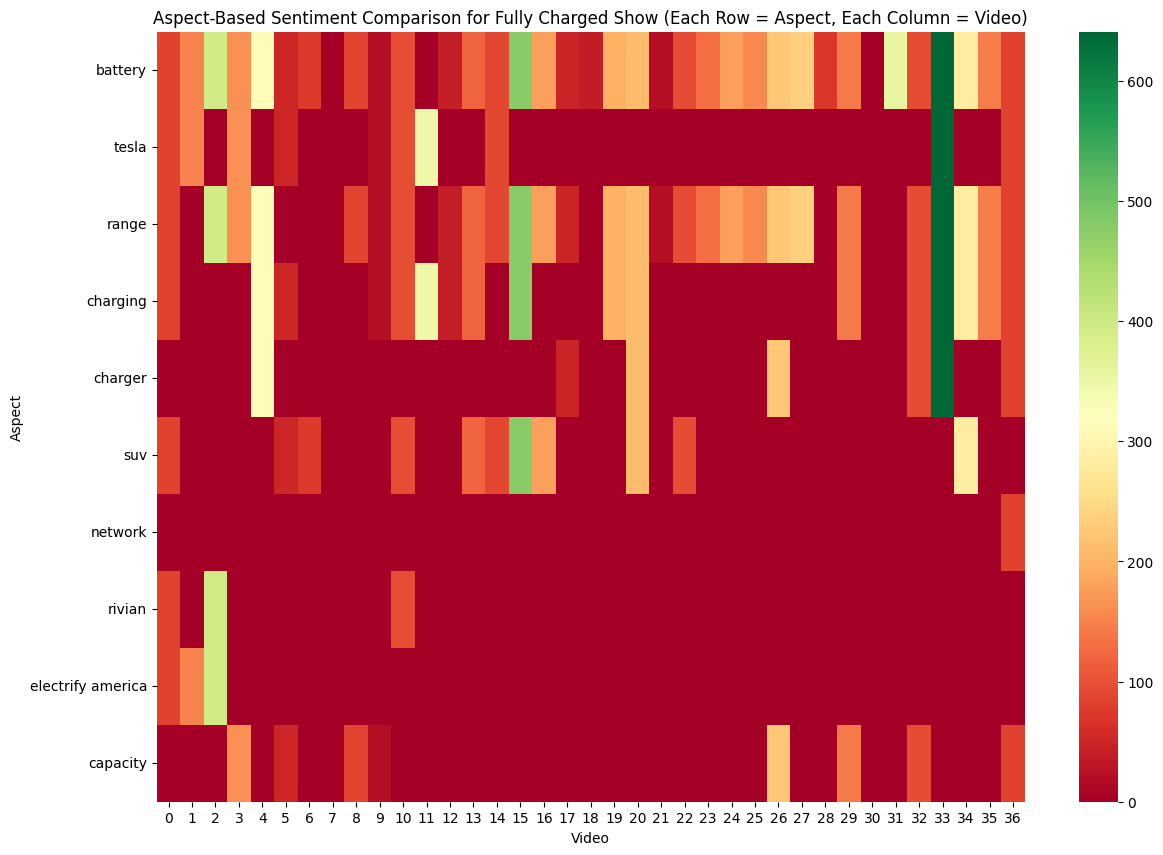

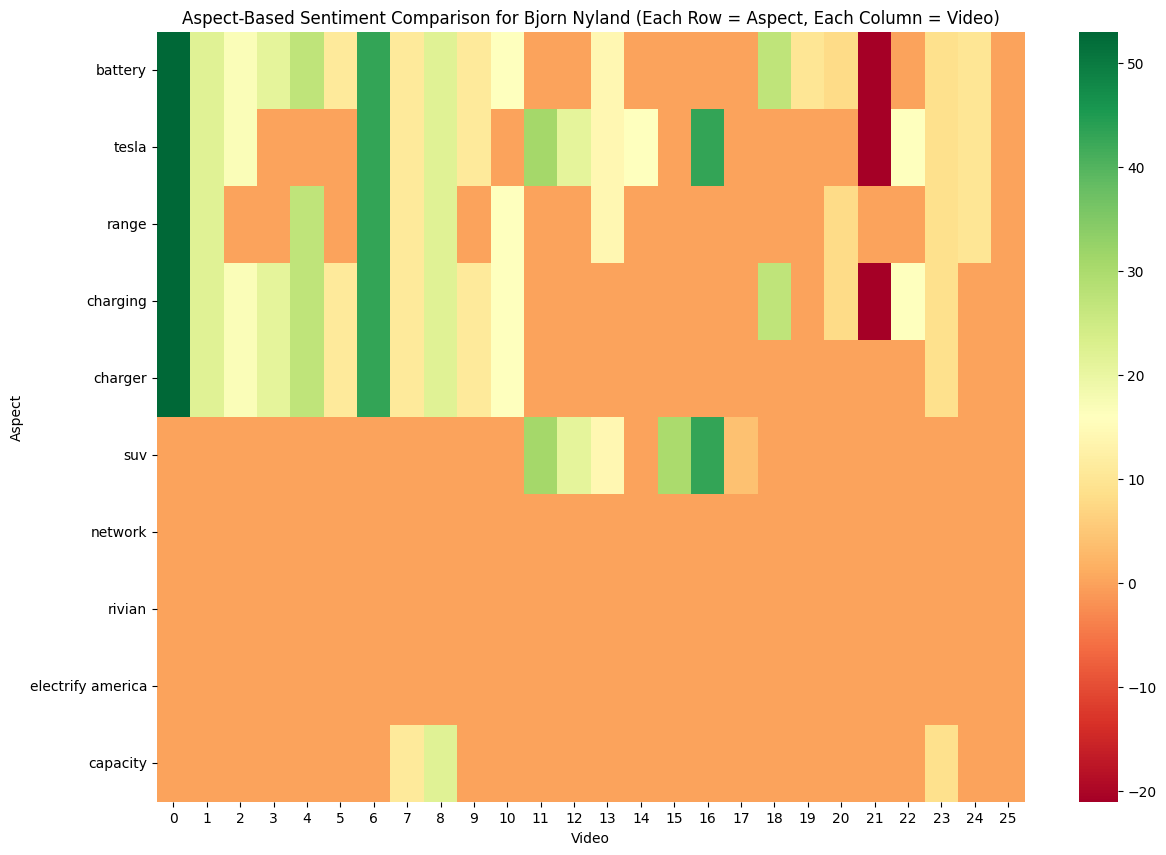

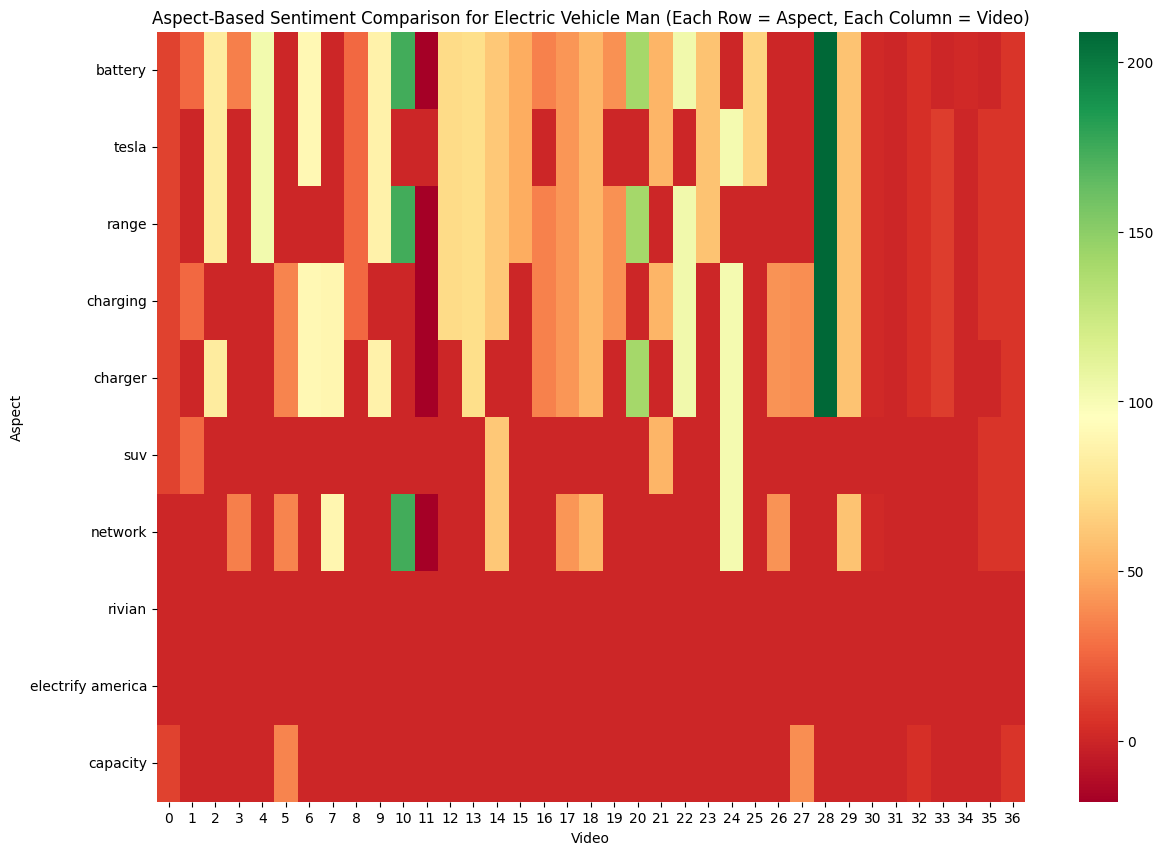

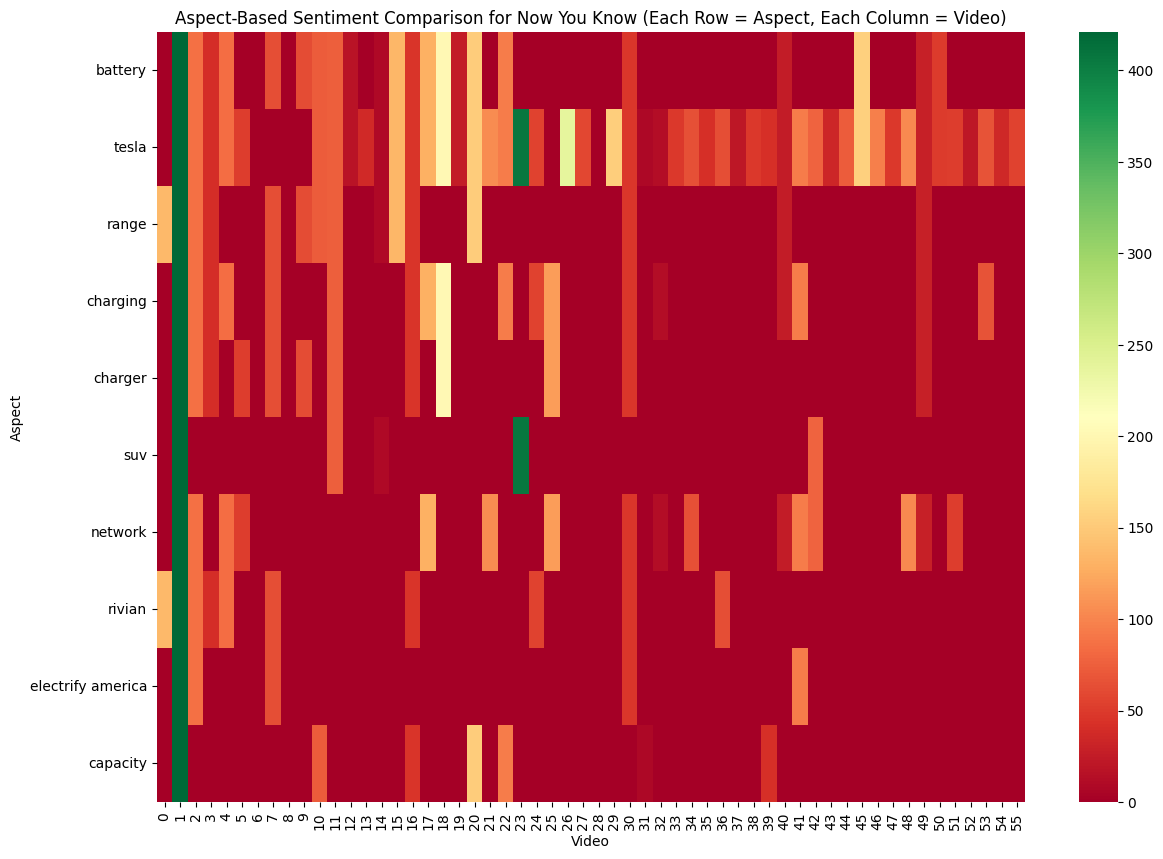

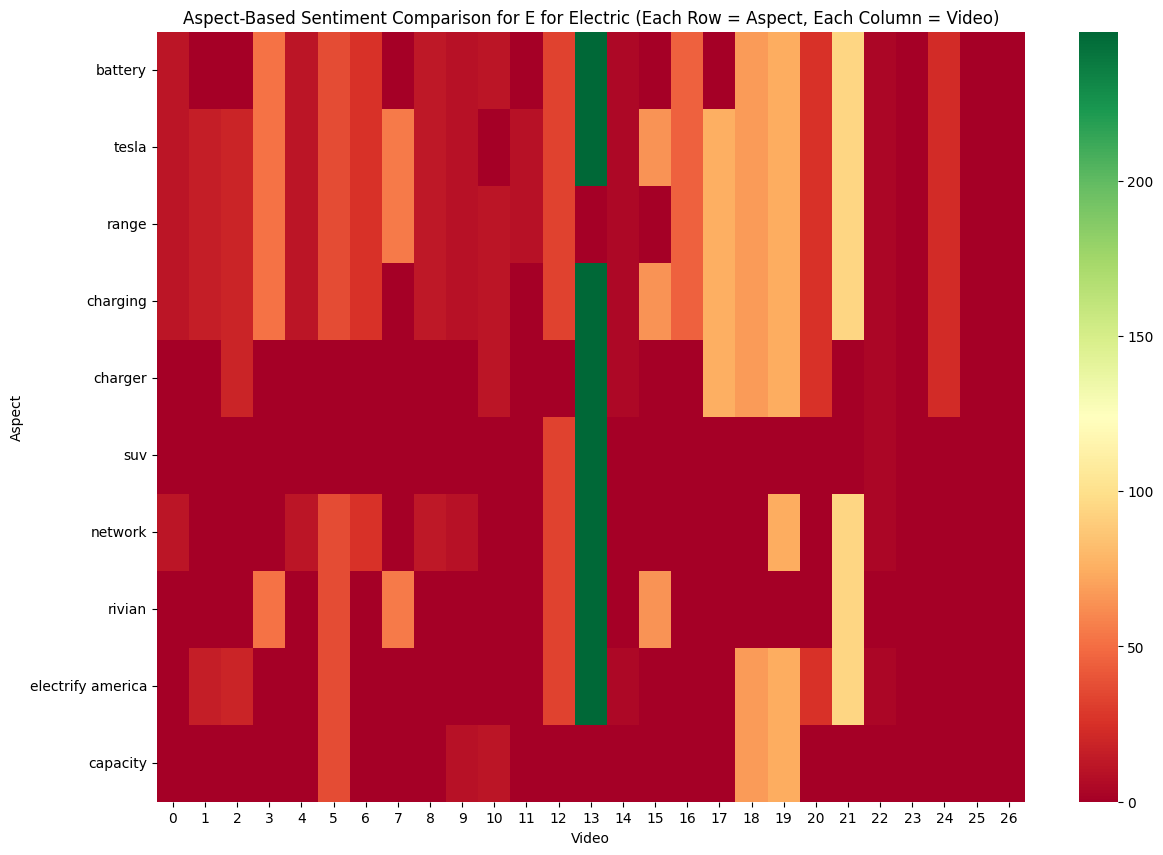

In [106]:
# Initialize the result list
topic_sentiment_matrix = []

# Loop through each creator
for creator in df["channel"].unique():
    creator_df = df_exploded[df_exploded["channel"] == creator]
    creator_aspect_sentiment = []

    # Loop through each video
    for video_id in creator_df["video_id"].unique():
        video_comments = creator_df[creator_df["video_id"] == video_id]
        aspect_sentiments = {aspect: 0 for aspect in top_topics}

        # Loop through each comment and its sentiment
        for aspects, sentiment in zip(video_comments["topics"], video_comments["sentiment_roberta"]):
            if aspects in aspect_sentiments:  # Ensure aspect is one of the top extracted aspects
                # Increment or decrement based on sentiment
                aspect_sentiments[aspects] += (
                    1 if sentiment == "positive" else -1 if sentiment == "negative" else 0
                )

        # Append sentiment values for this video
        creator_aspect_sentiment.append([aspect_sentiments[aspect] for aspect in top_topics])

    # Convert the list into a DataFrame for this creator
    creator_df_sentiment = pd.DataFrame(creator_aspect_sentiment, columns=top_topics)
    topic_sentiment_matrix.append((creator, creator_df_sentiment))  # Store creator and sentiment DataFrame

# Now, plot one heatmap per creator
for creator, sentiment_data in topic_sentiment_matrix:
    plt.figure(figsize=(14, 10))
    sns.heatmap(sentiment_data.T, annot=False, cmap="RdYlGn", fmt=".2f", cbar=True)
    plt.title(f"Aspect-Based Sentiment Comparison for {creator} (Each Row = Aspect, Each Column = Video)")
    plt.xlabel("Video")
    plt.ylabel("Aspect")
    plt.show()


In [107]:
creator_df_sentiment.to_csv("creator_df_sentiment_roberta.csv", index=True)

C:\Users\koole\AppData\Local\Temp\ipykernel_25872\169250631.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")


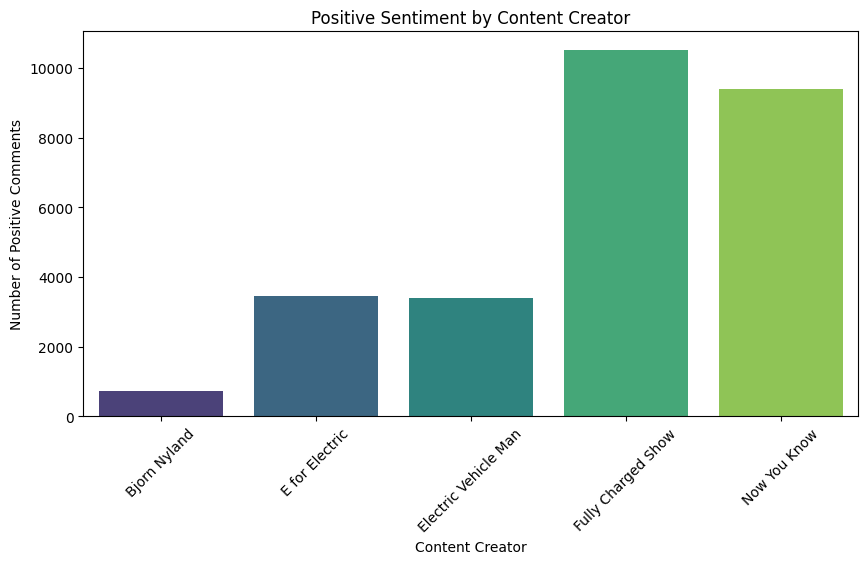

In [97]:
# Count the number of positive comments per creator
positive_comments_per_creator = df[df['sentiment_roberta'] == 'Positive'].groupby('channel').size()

# Plotting the number of positive comments per creator
plt.figure(figsize=(10, 5))
sns.barplot(x=positive_comments_per_creator.index, y=positive_comments_per_creator.values, palette="viridis")
plt.title("Positive Sentiment by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.show()

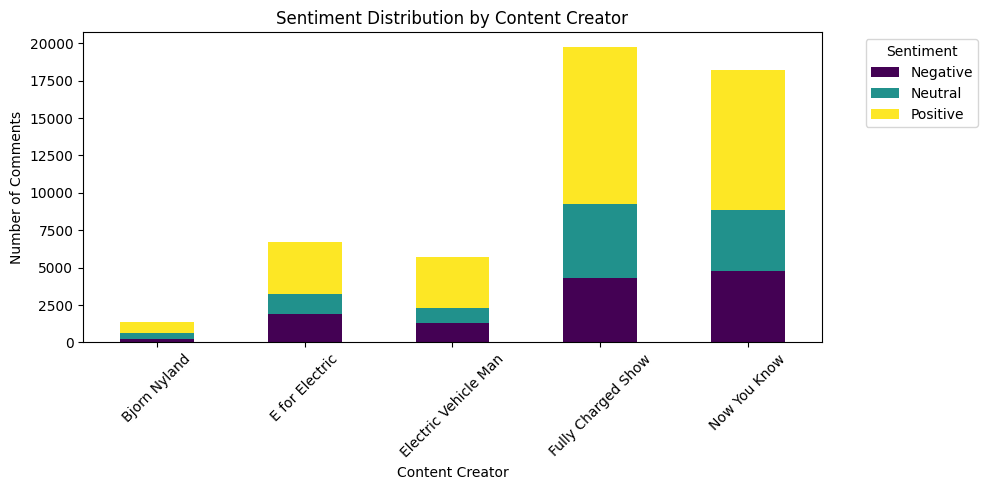

In [108]:
# Count the number of comments per sentiment per creator
comments_per_creator_sentiment = df.groupby(['channel', 'sentiment_roberta']).size().unstack(fill_value=0)

# Plotting the number of comments per sentiment (Positive, Negative, Neutral) per creator
comments_per_creator_sentiment.plot(kind='bar', stacked=True, figsize=(10, 5), colormap="viridis")

plt.title("Sentiment Distribution by Content Creator")
plt.xlabel("Content Creator")
plt.ylabel("Number of Comments")
plt.xticks(rotation=45)
plt.legend(title="Sentiment", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [109]:
comments_per_creator_sentiment.to_csv("comments_per_creator_sentiment_roberta.csv", index=False)

C:\Users\koole\AppData\Local\Temp\ipykernel_25872\3729426362.py:43: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df_melted, x="topics", y="Count", hue="Sentiment", palette="Set2", ci=None)


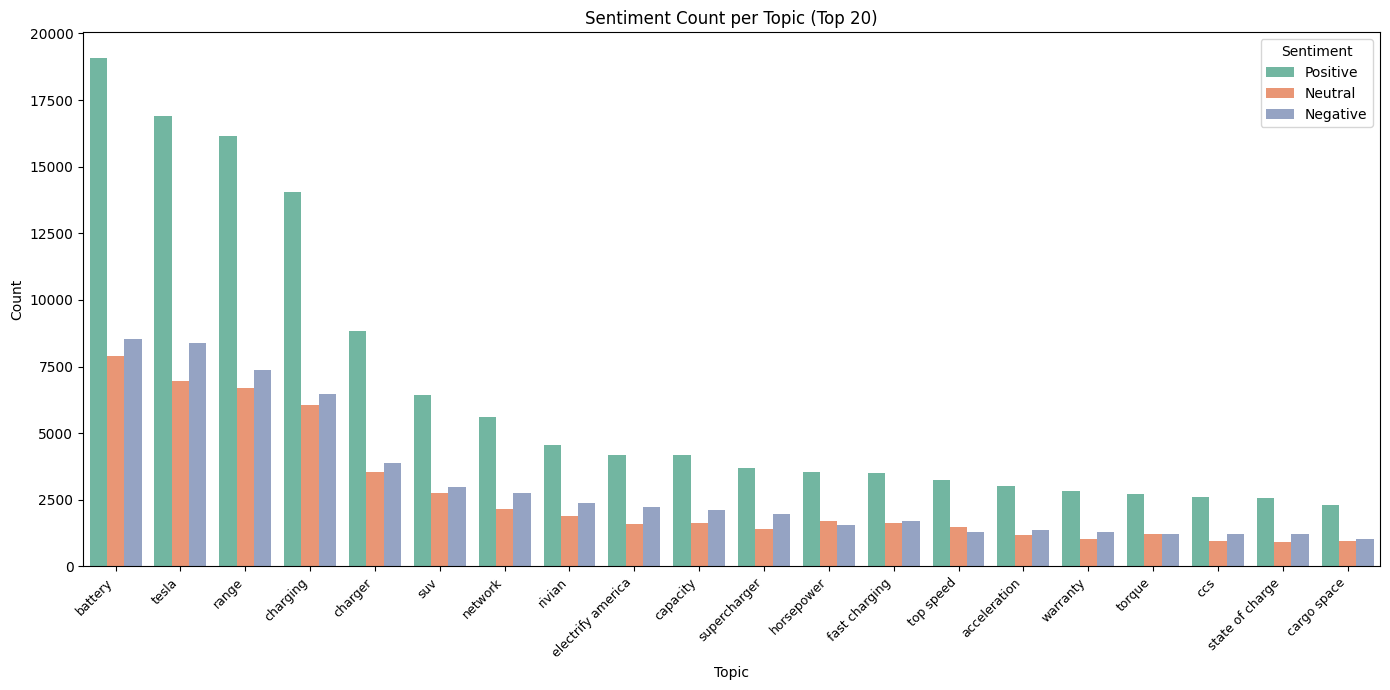

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast

# Step 1: Load the data
df = pd.read_csv("comment_sentiment_roberta_FineTuning.csv")

# Step 2: Remove existing sentiment columns if they exist
df = df.drop(columns=["Negative", "Neutral", "Positive"], errors="ignore")

# Step 3: Convert stringified lists in 'topics' column to actual Python lists
def safe_parse_topics(x):
    try:
        return ast.literal_eval(x) if isinstance(x, str) else x
    except:
        return [x]

df["topics"] = df["topics"].apply(safe_parse_topics)

# Step 4: One-hot encode sentiment_roberta column
df_sentiment = pd.get_dummies(df["sentiment_roberta"])  # Creates 'Negative', 'Neutral', 'Positive'
df = pd.concat([df, df_sentiment], axis=1)

# Step 5: Explode the topics
df_exploded = df.explode("topics")
df_exploded["topics"] = df_exploded["topics"].astype(str).str.lower().str.strip()

# Step 6: Group and aggregate sentiment counts
df_grouped = df_exploded.groupby("topics", as_index=False)[["Negative", "Neutral", "Positive"]].sum()

# Step 7: Get top 20 topics by total sentiment count
df_grouped["Total"] = df_grouped[["Negative", "Neutral", "Positive"]].sum(axis=1)
df_grouped = df_grouped.sort_values("Total", ascending=False).head(20)

# Step 8: Melt the data for seaborn
df_melted = df_grouped.melt(id_vars="topics",
                            value_vars=["Positive", "Neutral", "Negative"],
                            var_name="Sentiment", value_name="Count")

# Step 9: Plot
plt.figure(figsize=(14, 7))
sns.barplot(data=df_melted, x="topics", y="Count", hue="Sentiment", palette="Set2", ci=None)
plt.title("Sentiment Count per Topic (Top 20)")
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.xlabel("Topic")
plt.ylabel("Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


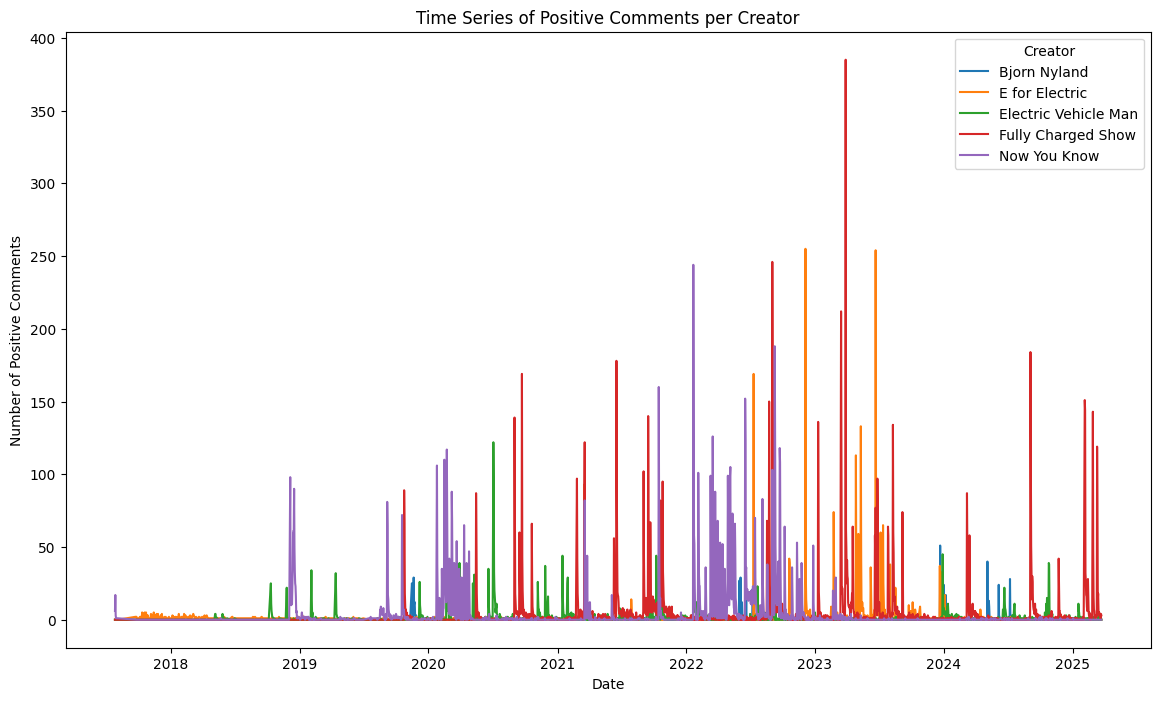

In [112]:
# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Time series of the number of positive comments received per creator
positive_comment_time_series = df[df['sentiment_roberta'] == 'Positive'].groupby(['date', 'channel']).size().unstack(fill_value=0)
positive_comment_time_series.plot(figsize=(14, 8), title="Time Series of Positive Comments per Creator")
plt.ylabel('Number of Positive Comments')
plt.xlabel('Date')
plt.legend(title="Creator")
plt.show()

In [113]:
positive_comment_time_series.to_csv("positive_comment_time_series_roberta.csv", index=True)

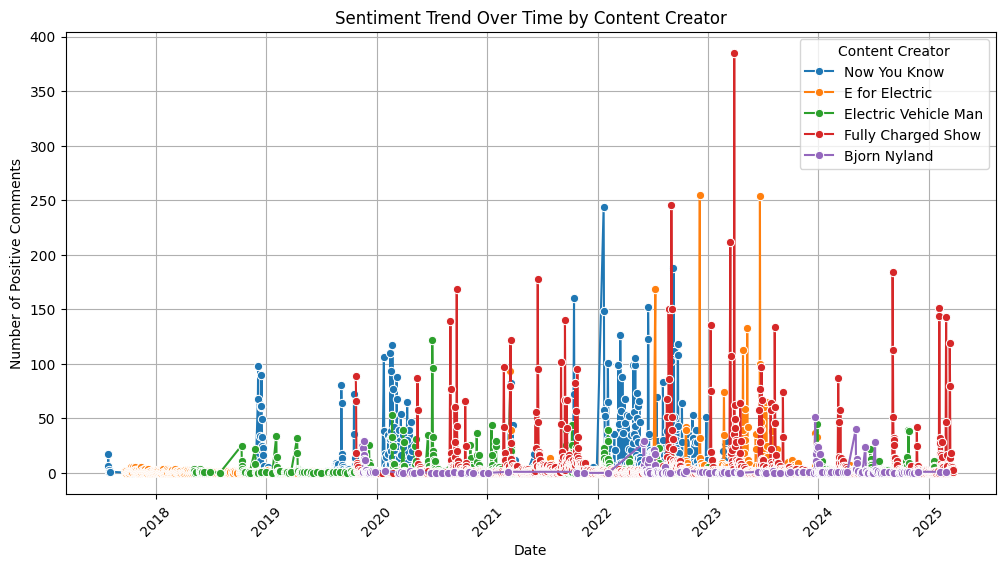

In [114]:
# Sentiment Distribution per Aspect
aspect_sentiment = df.explode("topics").groupby(["topics", "sentiment_roberta"]).size().unstack(fill_value=0)

# Compare Content Creators based on Sentiment
creator_sentiment = df.groupby(["channel", "sentiment_roberta"]).size().unstack(fill_value=0)

# Visualization: Sentiment Trends Over Time
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["date"] = pd.to_datetime(df["timestamp"]).dt.date  # Ensure it's a proper date

# Aggregate sentiment counts per date and channel
sentiment_counts = df.groupby(["date", "channel"])["sentiment_roberta"].value_counts().unstack(fill_value=0).reset_index()

# Convert "date" back to datetime type
sentiment_counts["date"] = pd.to_datetime(sentiment_counts["date"])

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=sentiment_counts, x="date", y="Positive", hue="channel", marker="o")

plt.title("Sentiment Trend Over Time by Content Creator")
plt.xlabel("Date")
plt.ylabel("Number of Positive Comments")
plt.xticks(rotation=45)
plt.legend(title="Content Creator")
plt.grid()
plt.show()


**Outdated**

In [ ]:
# --- 1. Fine-tune RoBERTa using Triplet Loss (with Neutral class included) ---

from torch.nn.functional import cosine_similarity
from torch.utils.data import Dataset, DataLoader

class TripletDataset(Dataset):
    def __init__(self, anchor_texts, positive_texts, negative_texts):
        self.anchor_texts = anchor_texts
        self.positive_texts = positive_texts
        self.negative_texts = negative_texts

    def __len__(self):
        return len(self.anchor_texts)

    def __getitem__(self, idx):
        return self.anchor_texts[idx], self.positive_texts[idx], self.negative_texts[idx]

# Create Triplets (anchor, positive, negative)
triplets = []
for sentiment_class in ['Positive', 'Negative', 'Neutral']:
    texts = df[df['sentiment_vader'] == sentiment_class]['cleaned_text'].tolist()
    for i in range(len(texts) - 2):
        triplets.append((texts[i], texts[i+1], random.choice(df[df['sentiment_vader'] != sentiment_class]['cleaned_text'].tolist())))

# Create DataLoader
triplet_dataset = TripletDataset(*zip(*triplets))
triplet_loader = DataLoader(triplet_dataset, batch_size=8, shuffle=True)

# Redefine encoding to handle batch
class TripletEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

    def forward(self, texts):
        encoded = self.tokenizer(list(texts), padding=True, truncation=True, return_tensors='pt').to(device)
        with torch.set_grad_enabled(self.training):
            outputs = self.encoder(**encoded)
        return outputs.last_hidden_state.mean(dim=1)  # Mean pooling

triplet_model = TripletEncoder(model_name).to(device)
optimizer = torch.optim.AdamW(triplet_model.parameters(), lr=2e-5)

# Triplet Loss
triplet_loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)

# Training Loop
triplet_model.train()
for epoch in range(3):
    total_loss = 0
    for anchor, positive, negative in tqdm(triplet_loader, desc=f"Epoch {epoch+1}"):
        anchor_emb = triplet_model(anchor)
        positive_emb = triplet_model(positive)
        negative_emb = triplet_model(negative)

        loss = triplet_loss_fn(anchor_emb, positive_emb, negative_emb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1} Loss: {total_loss / len(triplet_loader):.4f}")

# Save the model
triplet_model.encoder.save_pretrained("triplet-roberta-absa")
triplet_model.tokenizer.save_pretrained("triplet-roberta-absa")


# --- 2. Evaluate Learned Embeddings with Classifier ---

# Generate embeddings
all_comments = df['cleaned_text'].tolist()
all_labels = df['sentiment_vader'].map({"Negative": 0, "Neutral": 1, "Positive": 2}).tolist()

triplet_model.eval()
embeddings = []
with torch.no_grad():
    for i in range(0, len(all_comments), 32):
        batch = all_comments[i:i+32]
        emb = triplet_model(batch).cpu().numpy()
        embeddings.append(emb)

embeddings = np.vstack(embeddings)

# Train classifier on embeddings
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(embeddings, all_labels, test_size=0.2, random_state=42)
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Negative", "Neutral", "Positive"]))


# --- 3. Use Fine-Tuned Model for ABSA ---

# Use triplet_model to encode comments
aspect_embeddings = []
aspect_texts = df['cleaned_text'].tolist()
with torch.no_grad():
    for i in range(0, len(aspect_texts), 32):
        batch = aspect_texts[i:i+32]
        emb = triplet_model(batch).cpu().numpy()
        aspect_embeddings.append(emb)

df['aspect_embedding'] = list(np.vstack(aspect_embeddings))

# You can now cluster aspect embeddings or compare comment similarity per topic
# Example: cluster per topic
from sklearn.cluster import KMeans

topic_aspects = {}
for topic in df['topics'].explode().dropna().unique():
    topic_df = df[df['topics'].apply(lambda x: topic in x if isinstance(x, list) else False)]
    km = KMeans(n_clusters=3, random_state=42).fit(list(topic_df['aspect_embedding']))
    topic_df['cluster'] = km.labels_
    topic_aspects[topic] = topic_df[['comment', 'cluster']]

# Print example aspect clustering
for topic, result in topic_aspects.items():
    print(f"\nTopic: {topic}")
    print(result.groupby('cluster').head(3))



In [ ]:
import json
import re
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
import random
from tqdm import tqdm
import numpy as np

# Load Data
with open("data.json", "r", encoding="utf-8") as f:
    data = json.load(f)

# Flatten JSON
flattened_data = []
for channel, playlists in data.items():
    for playlist_id, videos in playlists.items():
        for video_id, video_data in videos.items():
            topics = video_data.get("topic", [])
            for comment in video_data.get("comments", []):
                flattened_data.append({
                    "channel": channel,
                    "video_id": video_id,
                    "video_title": video_data.get("video_title", ""),
                    "timestamp": comment["Timestamp"],
                    "comment": comment["Comment"],
                    "topics": topics
                })

df = pd.DataFrame(flattened_data)

# Clean Text
def clean_text(text):
    if isinstance(text, list): text = ' '.join(text)
    if not isinstance(text, str): return ""
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = ' '.join([w for w in text.split() if w not in stopwords.words("english")])
    return text.strip()

df["cleaned_text"] = df["comment"].apply(clean_text)

# VADER Sentiment
vader = SentimentIntensityAnalyzer()
def get_vader_sentiment(text):
    scores = vader.polarity_scores(text)
    return "Positive" if scores["compound"] >= 0.05 else "Negative" if scores["compound"] <= -0.05 else "Neutral"

df["sentiment_vader"] = df["cleaned_text"].apply(get_vader_sentiment)

# Initialize RoBERTa
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")

# Triplet Dataset
class TripletDataset(Dataset):
    def __init__(self, triplets):
        self.triplets = triplets
    def __len__(self): return len(self.triplets)
    def __getitem__(self, idx):
        a, p, n = self.triplets[idx]
        return a, p, n

def encode(text):
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128)
    return inputs.to(model.device)

def get_embedding(text):
    with torch.no_grad():
        inputs = encode(text)
        return model(**inputs).last_hidden_state.mean(dim=1)

# Build triplet training samples
def generate_triplets(df, max_triplets=5000):
    positives = df[df["sentiment_vader"] == "Positive"]["cleaned_text"].tolist()
    negatives = df[df["sentiment_vader"] == "Negative"]["cleaned_text"].tolist()
    neutrals = df[df["sentiment_vader"] == "Neutral"]["cleaned_text"].tolist()

    triplets = []
    for anchor_list, positive_list in [ (positives, positives), (negatives, negatives), (neutrals, neutrals) ]:
        if len(anchor_list) < 2: continue
        for _ in range(min(max_triplets, len(anchor_list))):
            a, p = random.sample(anchor_list, 2)
            neg_source = random.choice([l for l in [positives, negatives, neutrals] if l is not anchor_list])
            n = random.choice(neg_source)
            triplets.append((a, p, n))
    return triplets

triplets = generate_triplets(df)

# Dataloader
triplet_dataset = TripletDataset(triplets)
triplet_loader = DataLoader(triplet_dataset, batch_size=16, shuffle=True)

# Triplet loss
def triplet_loss(anchor, positive, negative, margin=1.0):
    pos_sim = F.cosine_similarity(anchor, positive)
    neg_sim = F.cosine_similarity(anchor, negative)
    return torch.mean(F.relu(margin + neg_sim - pos_sim))

# Fine-tune
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

for epoch in range(3):
    total_loss = 0
    print(f"Epoch {epoch+1}")
    for anchor, positive, negative in tqdm(triplet_loader):
        a_embed = get_embedding(anchor)
        p_embed = get_embedding(positive)
        n_embed = get_embedding(negative)

        loss = triplet_loss(a_embed, p_embed, n_embed)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Avg Loss: {total_loss / len(triplet_loader):.4f}")

# Save fine-tuned model
model.save_pretrained("fine-tuned-roberta-triplet")
tokenizer.save_pretrained("fine-tuned-roberta-triplet")

# Evaluation using pseudo-labels (VADER)
model.eval()
def get_prediction(text):
    with torch.no_grad():
        emb = get_embedding(text).cpu().numpy().flatten()
    return emb

# Build embeddings and classify using centroids
def build_centroid(sentiment_group):
    vectors = [get_prediction(text) for text in df[df["sentiment_vader"] == sentiment_group]["cleaned_text"]]
    return np.mean(vectors, axis=0)

centroids = {s: build_centroid(s) for s in ["Positive", "Negative", "Neutral"]}

def predict_sentiment(text):
    vec = get_prediction(text)
    sims = {label: F.cosine_similarity(torch.tensor(vec), torch.tensor(center), dim=0).item() for label, center in centroids.items()}
    return max(sims.items(), key=lambda x: x[1])[0]

df["predicted_sentiment"] = df["cleaned_text"].apply(predict_sentiment)
print(classification_report(df["sentiment_vader"], df["predicted_sentiment"], digits=3))

# ABSA (Aspect Sentiment Aggregation)
def absa_by_topic(df):
    topic_sentiments = {}
    for _, row in df.iterrows():
        for topic in row["topics"]:
            if topic not in topic_sentiments:
                topic_sentiments[topic] = {"Positive": 0, "Negative": 0, "Neutral": 0}
            topic_sentiments[topic][row["predicted_sentiment"]] += 1
    return pd.DataFrame(topic_sentiments).T

absa_results = absa_by_topic(df)
print(absa_results)


In [ ]:
def predict_sentiment(text):
    # Tokenize the text and prepare inputs
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=128).to(model.device)

    # Get the model's prediction (logits)
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits to probabilities and pick the class with the highest probability
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    sentiment_class = torch.argmax(probabilities, dim=1).item()  # Get the predicted class index

    # Map the class index to sentiment label
    sentiment_labels = ["Negative", "Neutral", "Positive"]
    sentiment = sentiment_labels[sentiment_class]

    return sentiment

# Apply the function to the cleaned text in your DataFrame
df["sentiment_roberta"] = df["cleaned_text"].apply(predict_sentiment)

# Example to see the new DataFrame with the predicted sentiment
print(df[["comment", "sentiment_roberta"]].head())

                                             comment sentiment_roberta
0  hi.  so you Guy proud of it please prove by buy 1          Positive
1  Tesla still the electric car to beat especiall...          Positive
2                            This didn’t age well……😂          Positive
3                  Good luck VIETNAMESE Electric Car          Positive
4  Why can't Mexico or any Latin American country...          Positive
